# Titanic

## Table of Contents
* [Data Exploration](#dataExploration)
* [Data Cleaning](#dataCleaning)
* [Feature Engineering](#featureEngineering)
* [Preprocessing](#preprocessing)
* [Feature Selection](#featureSelection)
* [Hyperparameter Optimization](#hyperparameterOptimization)
* [Model Selection](#modelSelection)

## TO DO
* gather all the metrics for model selection: confusion matrix, fit time, predict time, stability
* compute equity for each model, most important is recall
* bin age, fare?
* doc
* anchors
* git

In [628]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [629]:
# Matplotlib configuration
mpl.rcParams['figure.figsize'] = 15, 15
mpl.rcParams['figure.dpi'] = 300    # tells matplotlib to display inline plots at 300 DPI
mpl.rc("savefig", dpi = 300)        # tells matplotlib to save plots at 300 DPI

# Makes Jupyter show the output of all lines, not just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [630]:
df = pd.read_csv("titanic.csv")

<a id="dataExploration"><a/>

## Data Exploration

In [631]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [632]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [633]:
df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881138,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413493,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


### Variables Exploration

The 'boat', 'body' and 'ticket' variables are not useful to us as they do not help us in identifying survivors.

We will therefore drop them.

In [635]:
def plot_distribution_by_target(feature, bins=np.linspace(0, 85, 15), target="survived", labels=["died", "survived"], stack=False):
    # plots the distribution of the feature for both values of the boolean target
    # stack: wether to stack distribution or blend them, put True for int features
    if stack:
        plt.hist(
        x=[df[df[target] == 0][feature], 
        df[df[target] == 1][feature]], 
        stacked=True, 
        color=['r','g'],
        label=labels
    )
    else:
        plt.hist(df[df[target] == 0][feature], alpha=.6, label=labels[0], color="r")
        plt.hist(df[df[target] == 1][feature], alpha=.6, label=labels[1], color="g")
    title = "{} by {}".format(feature, target)
    plt.title(title)
    plt.legend(loc="upper left")
    plt.xlabel(feature)
    plt.ylabel("Number of passengers")
    plt.show()

In [636]:
df[["pclass", "survived"]].corr().iloc[0, 1]

-0.31246936264968

#### * survived: (boolean 0 = No; 1 = Yes)

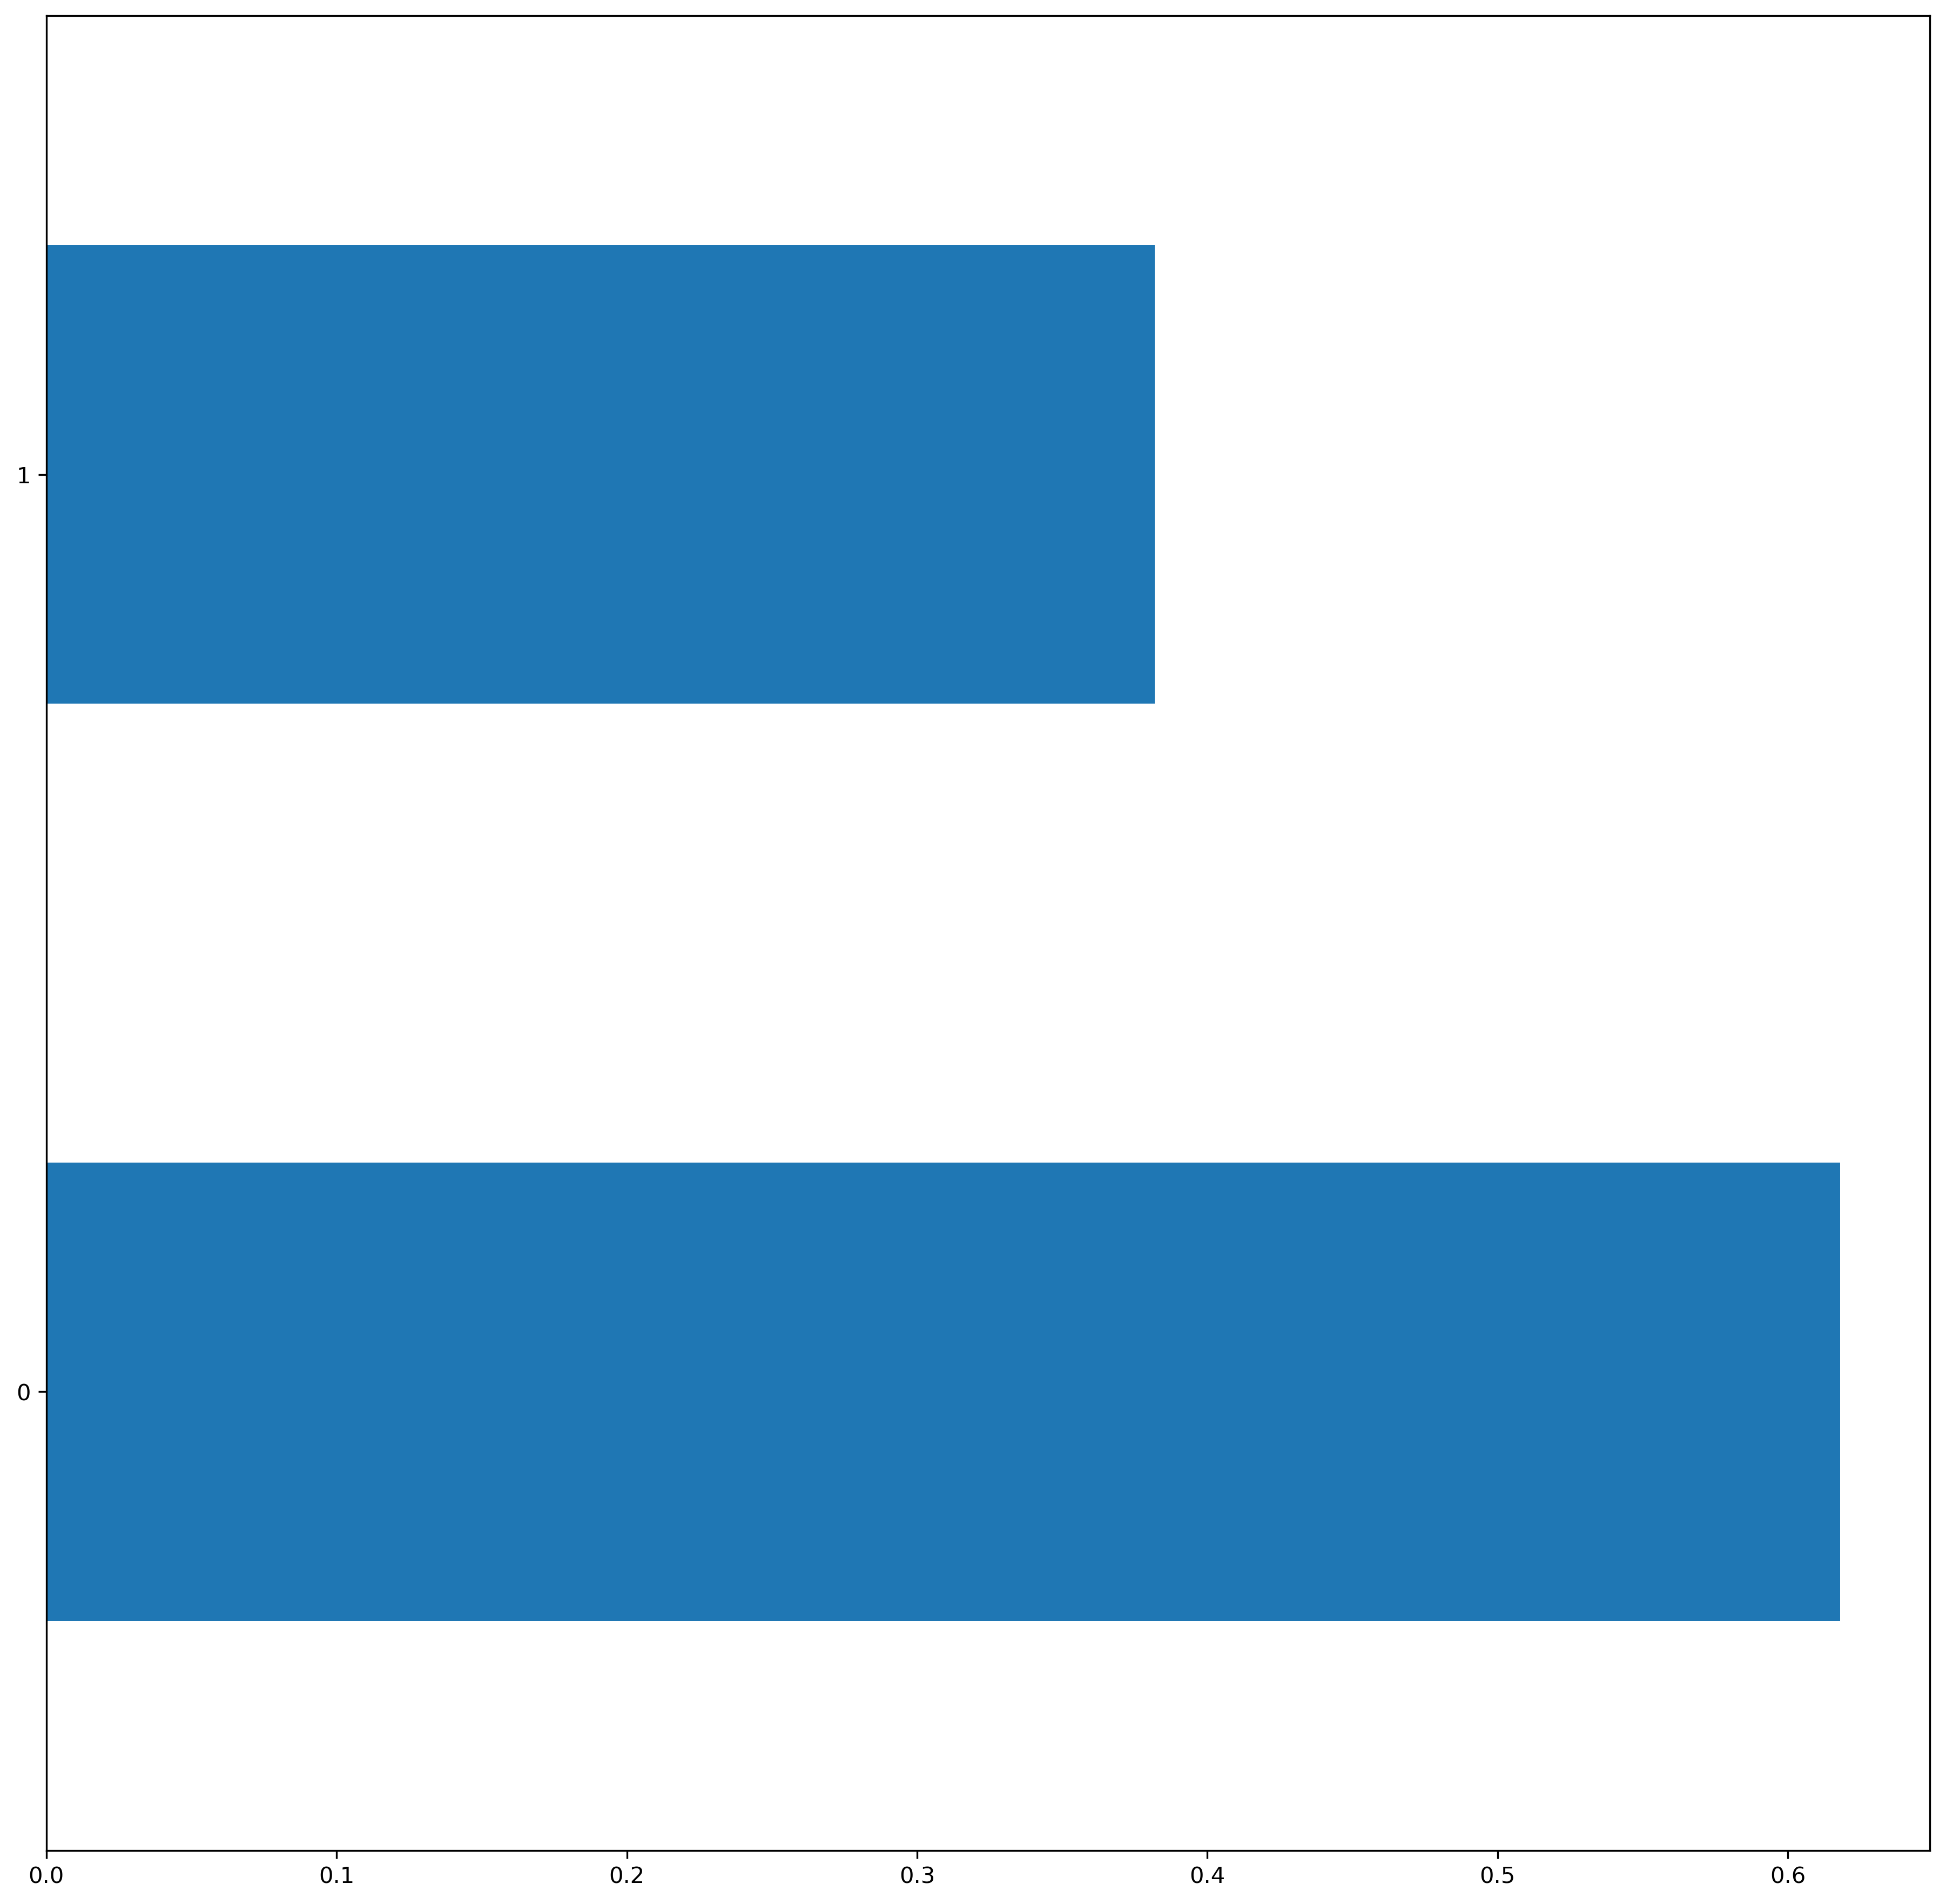

In [637]:
df.survived.value_counts(normalize=True).plot.barh();

Around 62% of passengers died.
Ideally, to have a balanced model, we would like to have a 50%/50% split, but this not too imbalanced either.

In [638]:
df.survived.isnull().sum()

0

There are no missing values

#### * pclass: Passenger class (ordinal 1 = 1st; 2 = 2nd; 3 = 3rd)

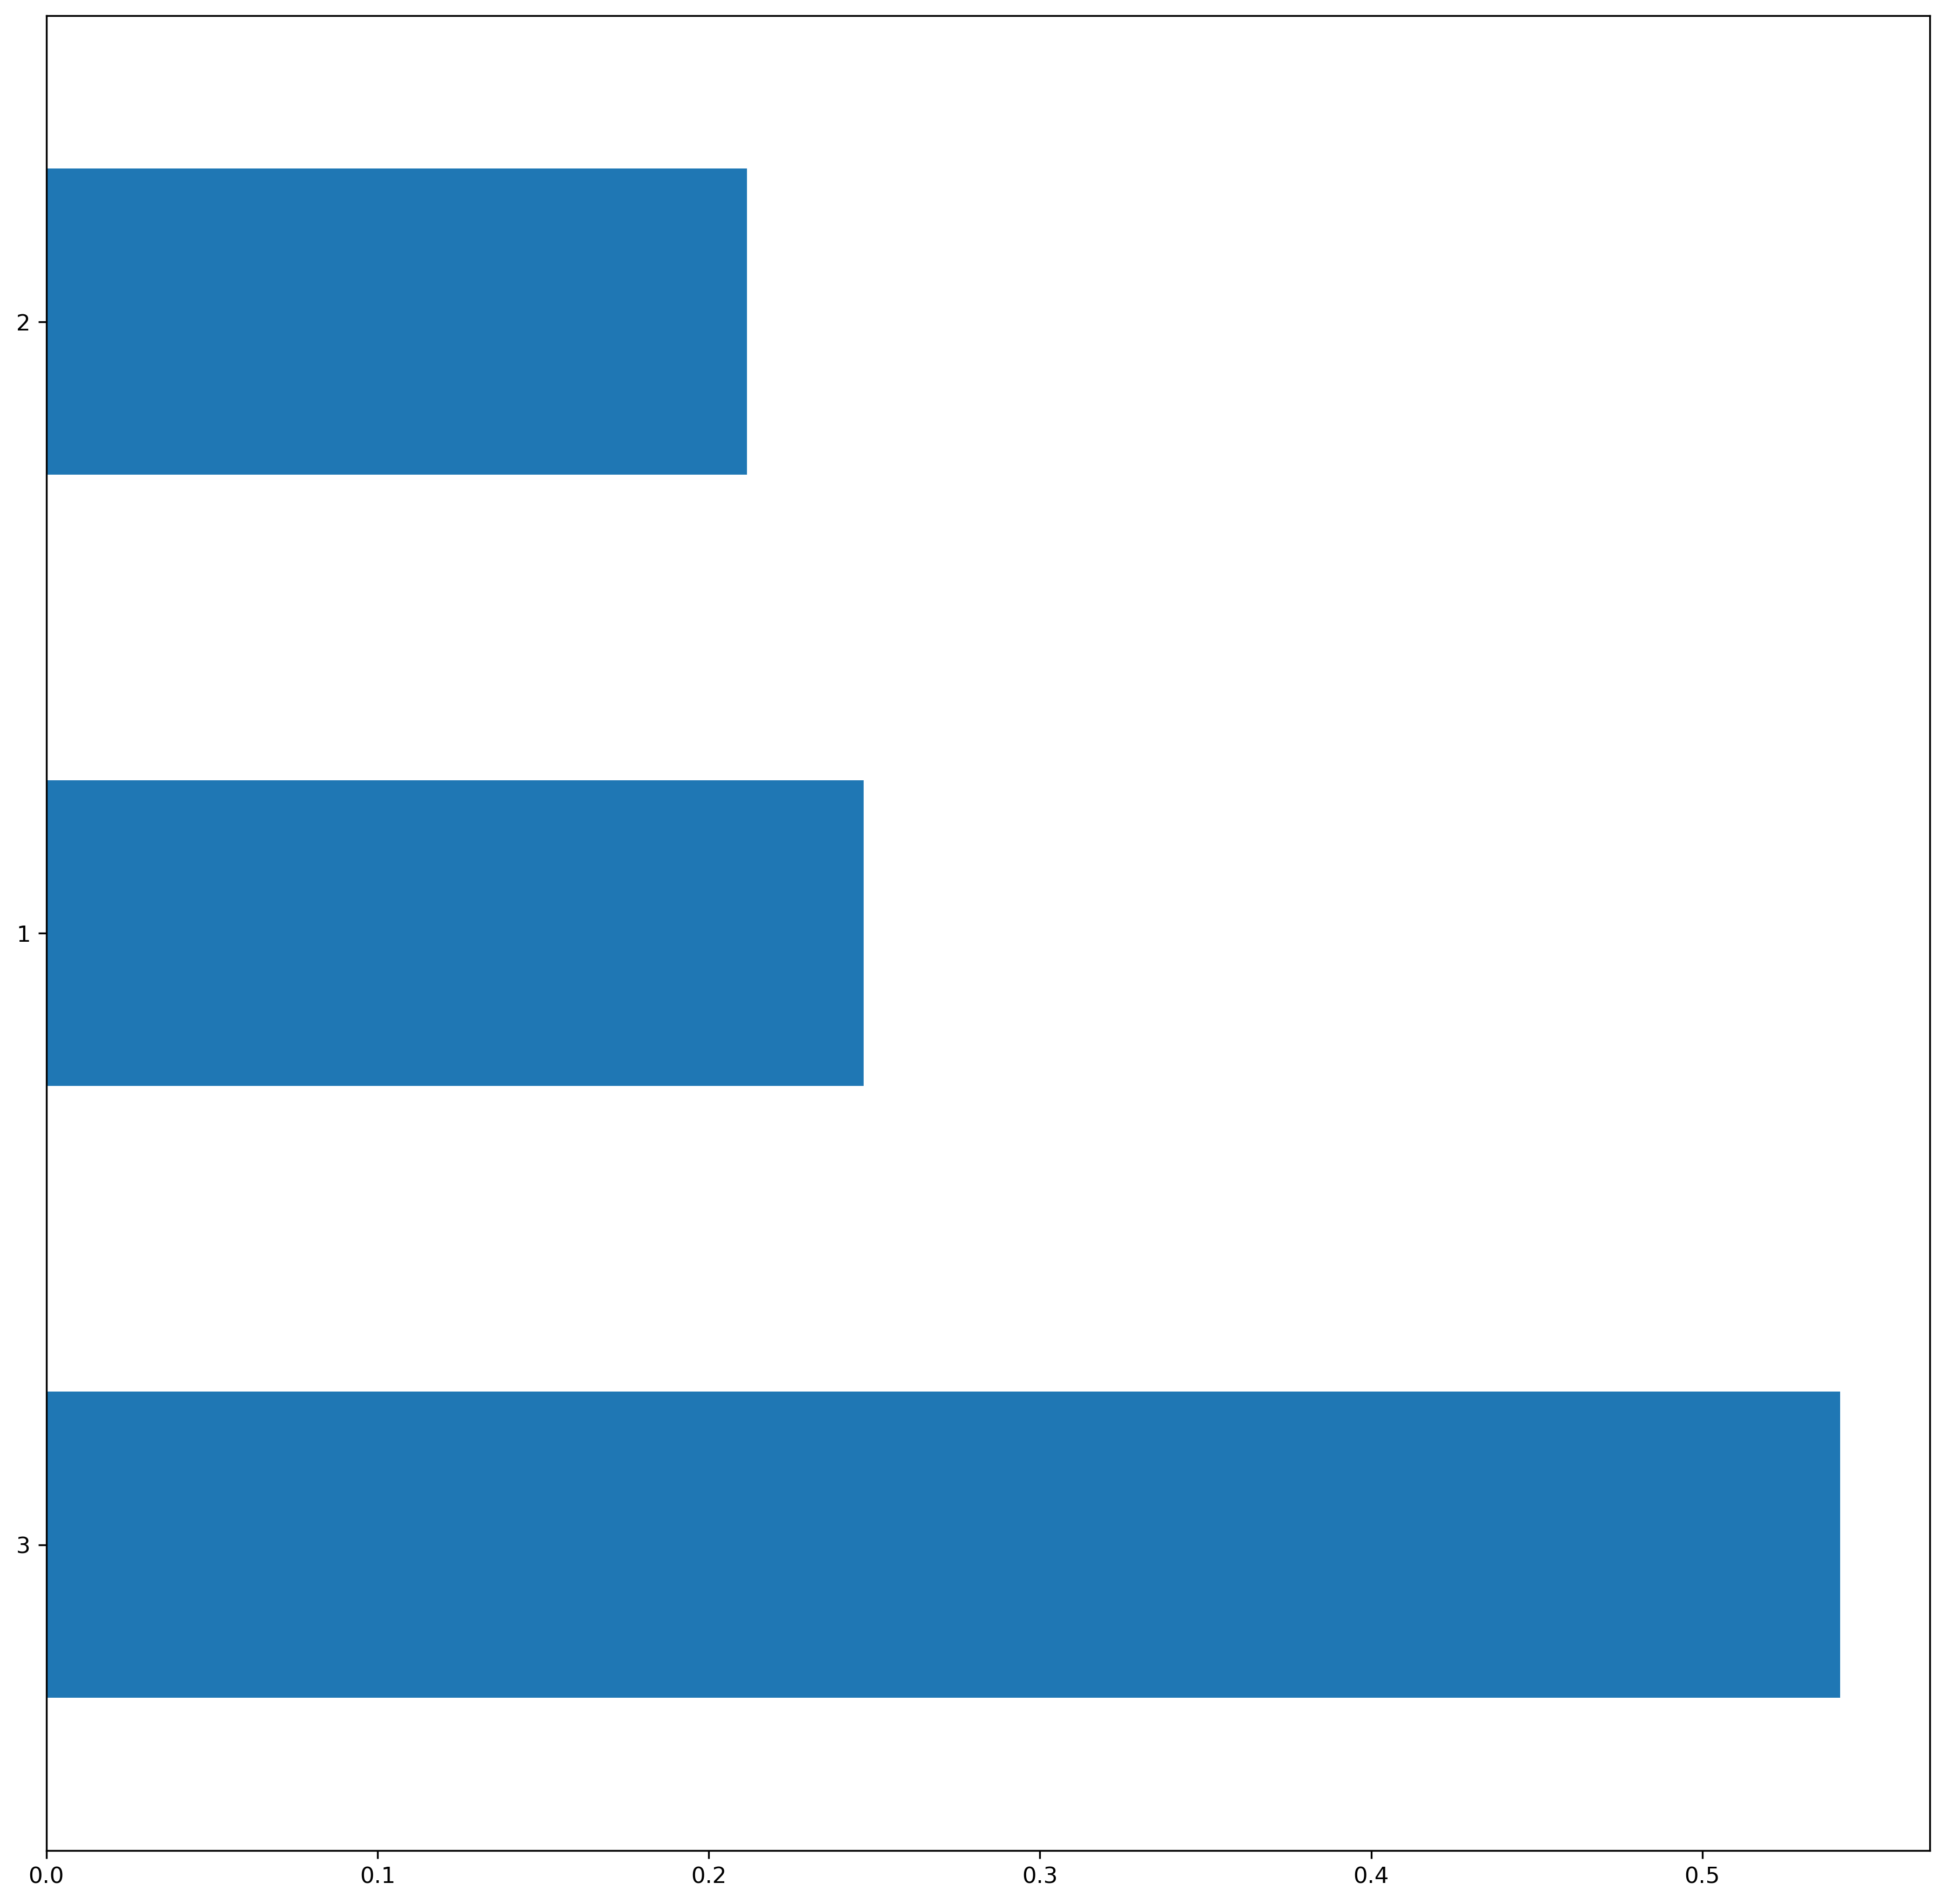

In [639]:
df.pclass.value_counts(normalize=True).plot.barh();

In [640]:
df.pclass.value_counts(normalize=True)

3    0.541635
1    0.246753
2    0.211612
Name: pclass, dtype: float64

The 3rd class clearly dominates with a presence of more that 54%.
Classes 1 and 2 are roughly evenly spread among the remaining passengers.

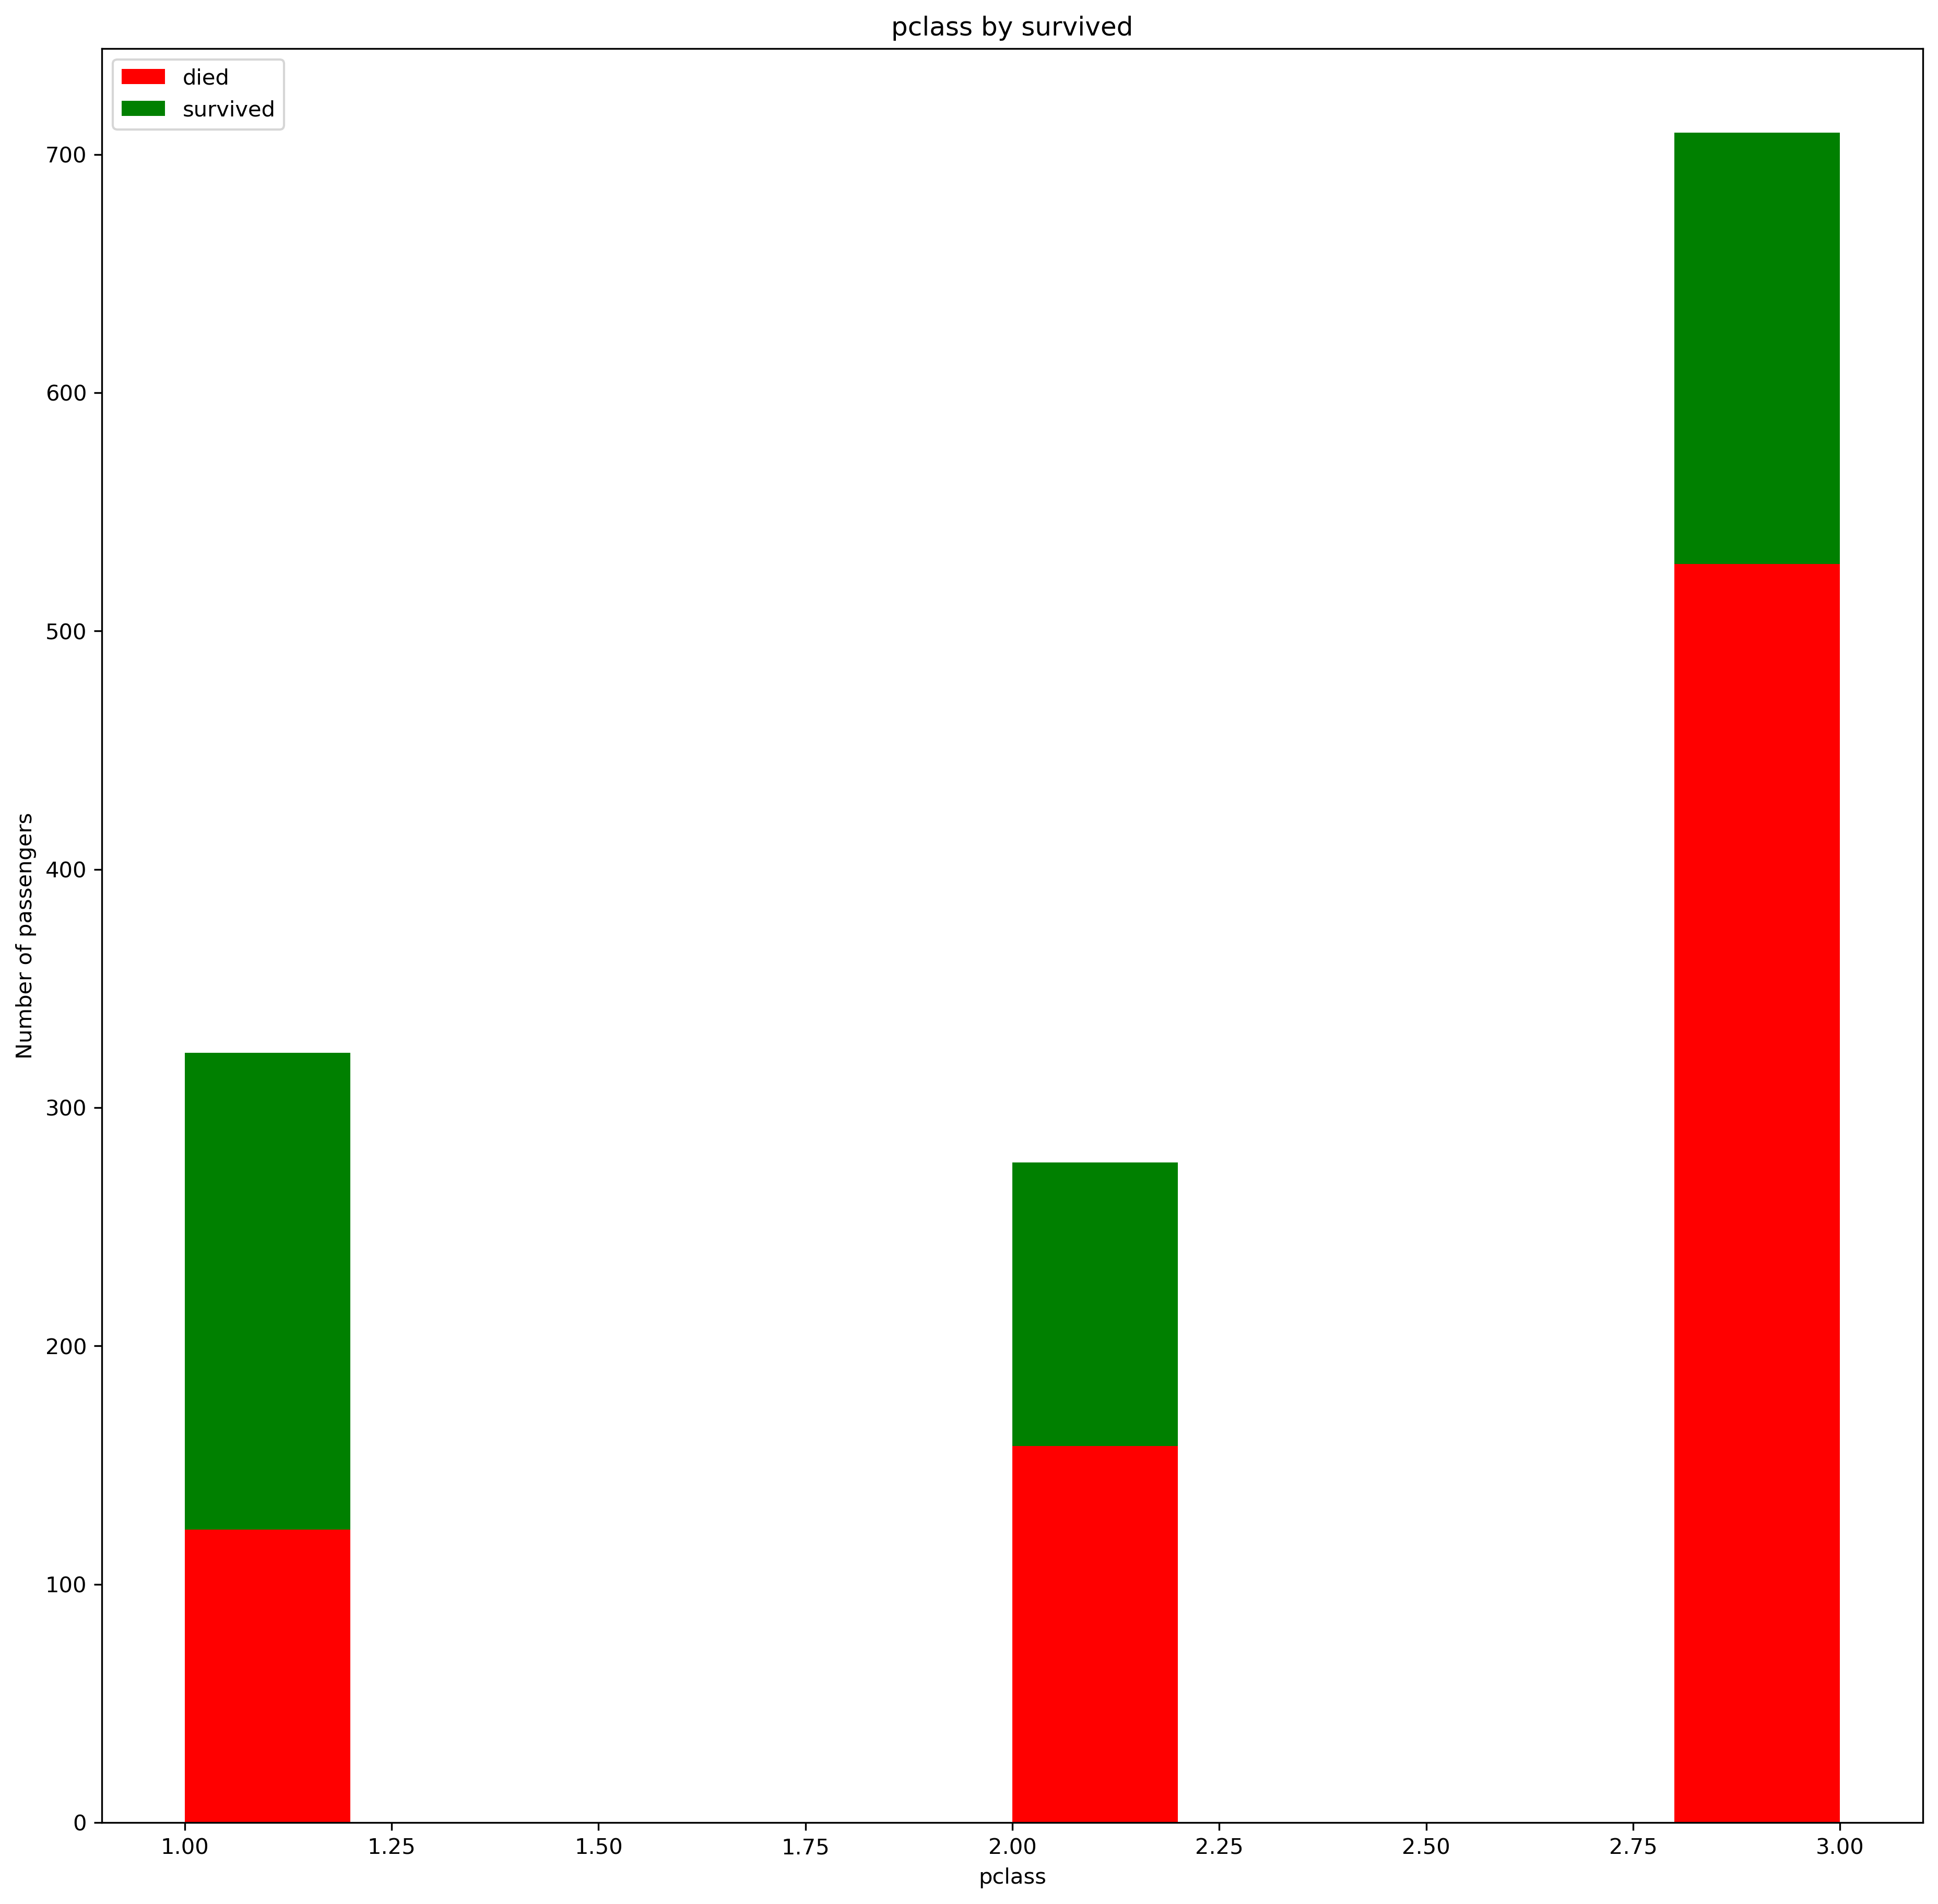

In [641]:
plot_distribution_by_target(feature="pclass", stack=True)

In [642]:
df.groupby("pclass").mean()["survived"]

pclass
1    0.619195
2    0.429603
3    0.255289
Name: survived, dtype: float64

The better the class, the better the probability of survival.

There is a 36% survival rate difference between the best and the worst class!

In [643]:
df.pclass.isnull().sum()

0

There are no missing values.

#### * name

In [644]:
df.name.isnull().sum()

0

There are no missing values.

This feature could be used to create new features.
We could imagine extracting titles from the name to capture new information about a passenger.

In [645]:
list(df.name.head())

['Allen, Miss. Elisabeth Walton',
 'Allison, Master. Hudson Trevor',
 'Allison, Miss. Helen Loraine',
 'Allison, Mr. Hudson Joshua Creighton',
 'Allison, Mrs. Hudson J C (Bessie Waldo Daniels)']

#### *sex 

In [646]:
df.sex.describe()

count     1309
unique       2
top       male
freq       843
Name: sex, dtype: object

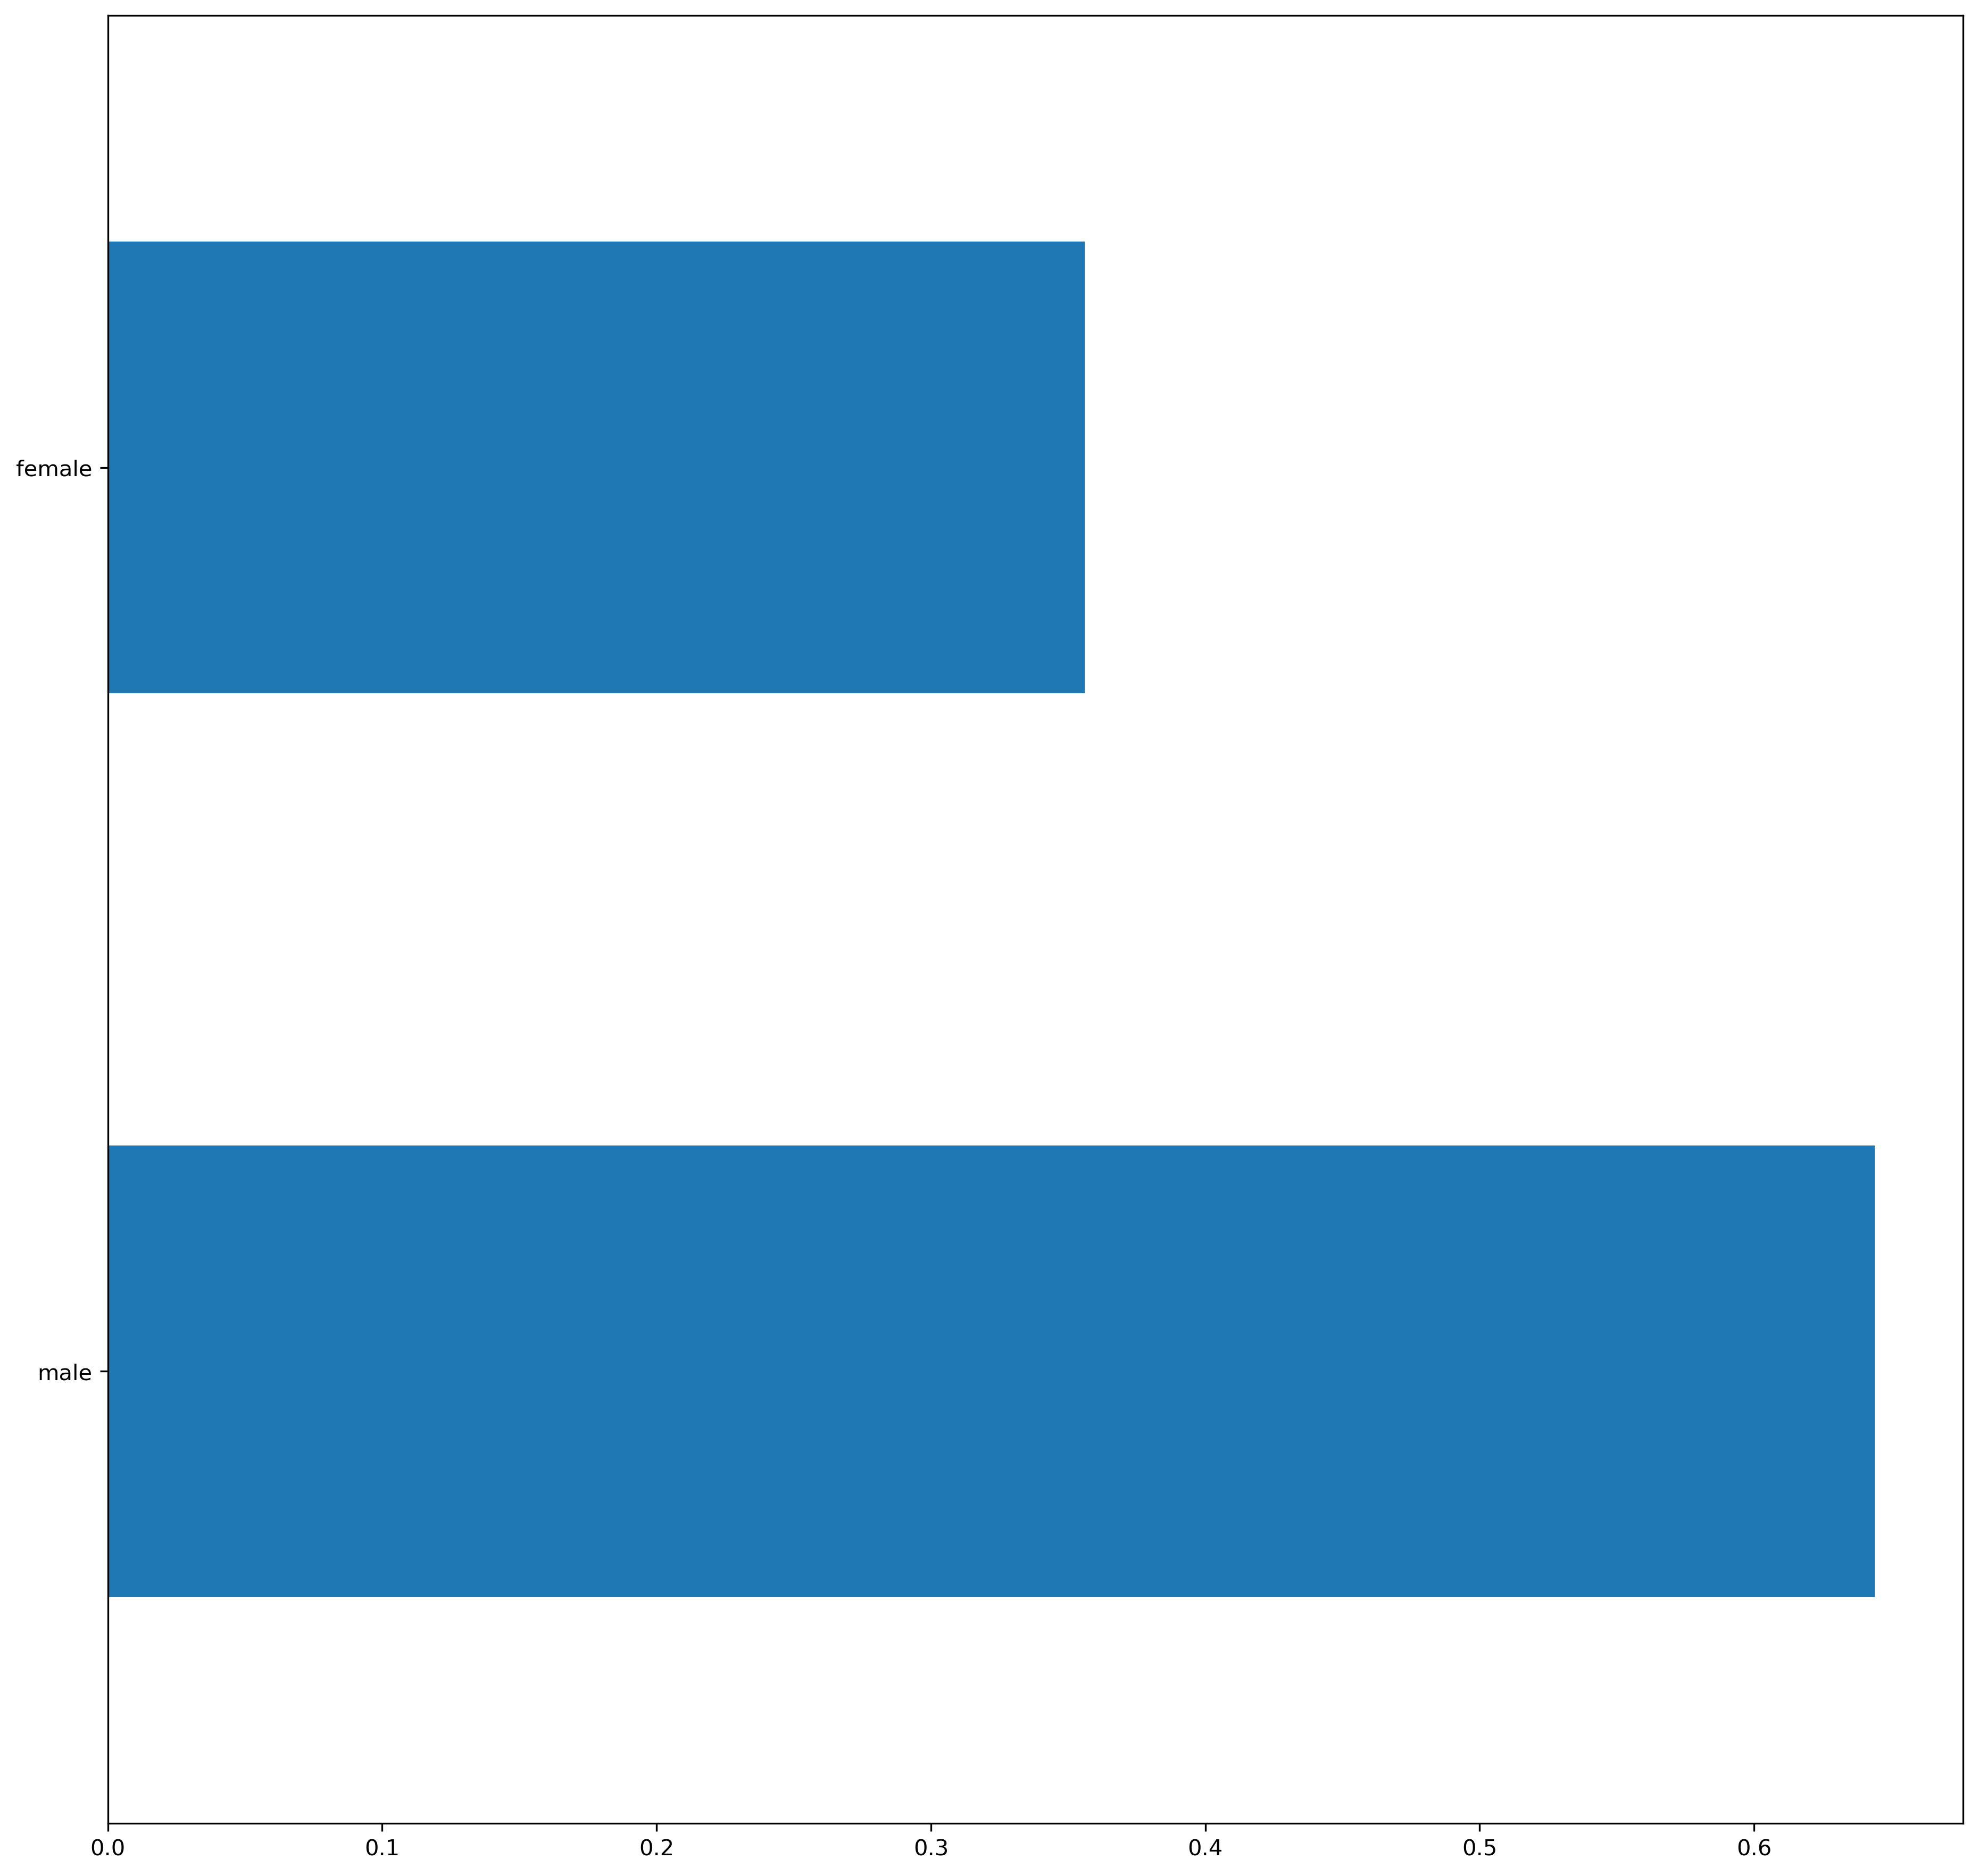

In [647]:
df.sex.value_counts(normalize=True).plot.barh();

We note a clear dominance of males over females with around 65% males.

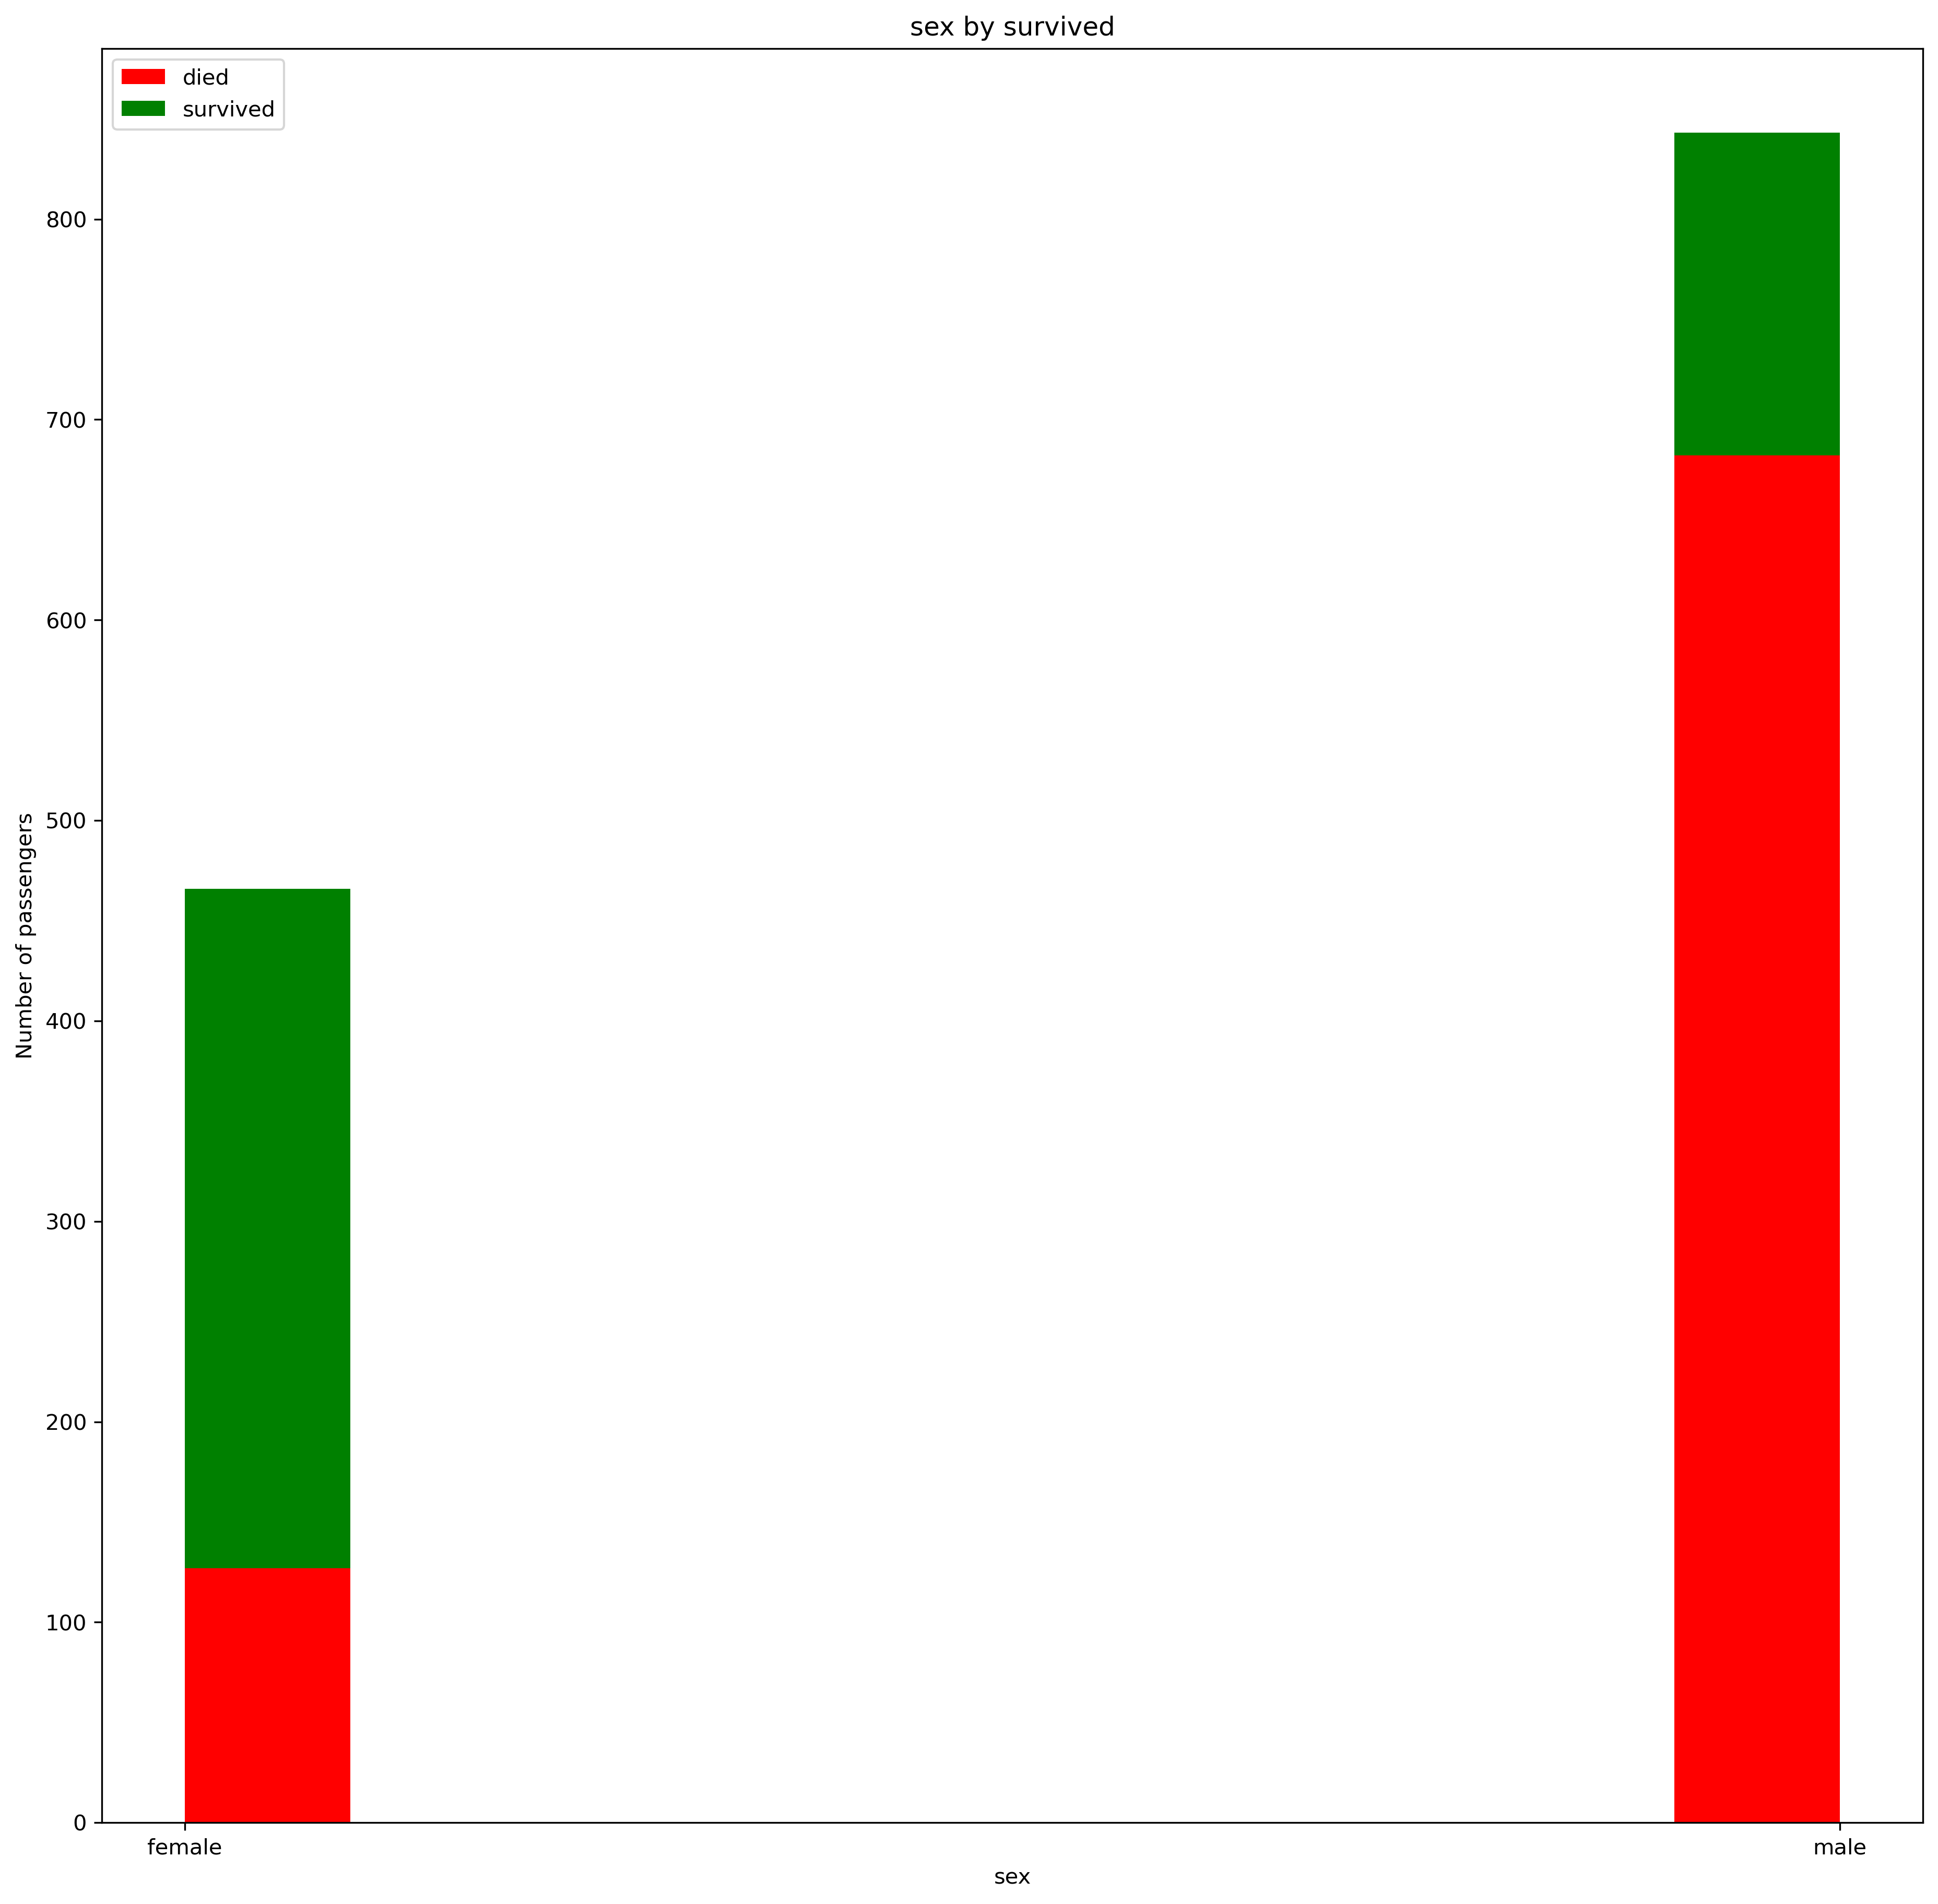

In [648]:
plot_distribution_by_target(feature="sex", stack=True)

In [649]:
df.groupby("sex").mean()["survived"]

sex
female    0.727468
male      0.190985
Name: survived, dtype: float64

We note a drastic survival rate advantage for females: a female is about 54% more likely to survive than a male is!

In [650]:
df.sex.isnull().sum()

0

There are no missing values.

#### * age

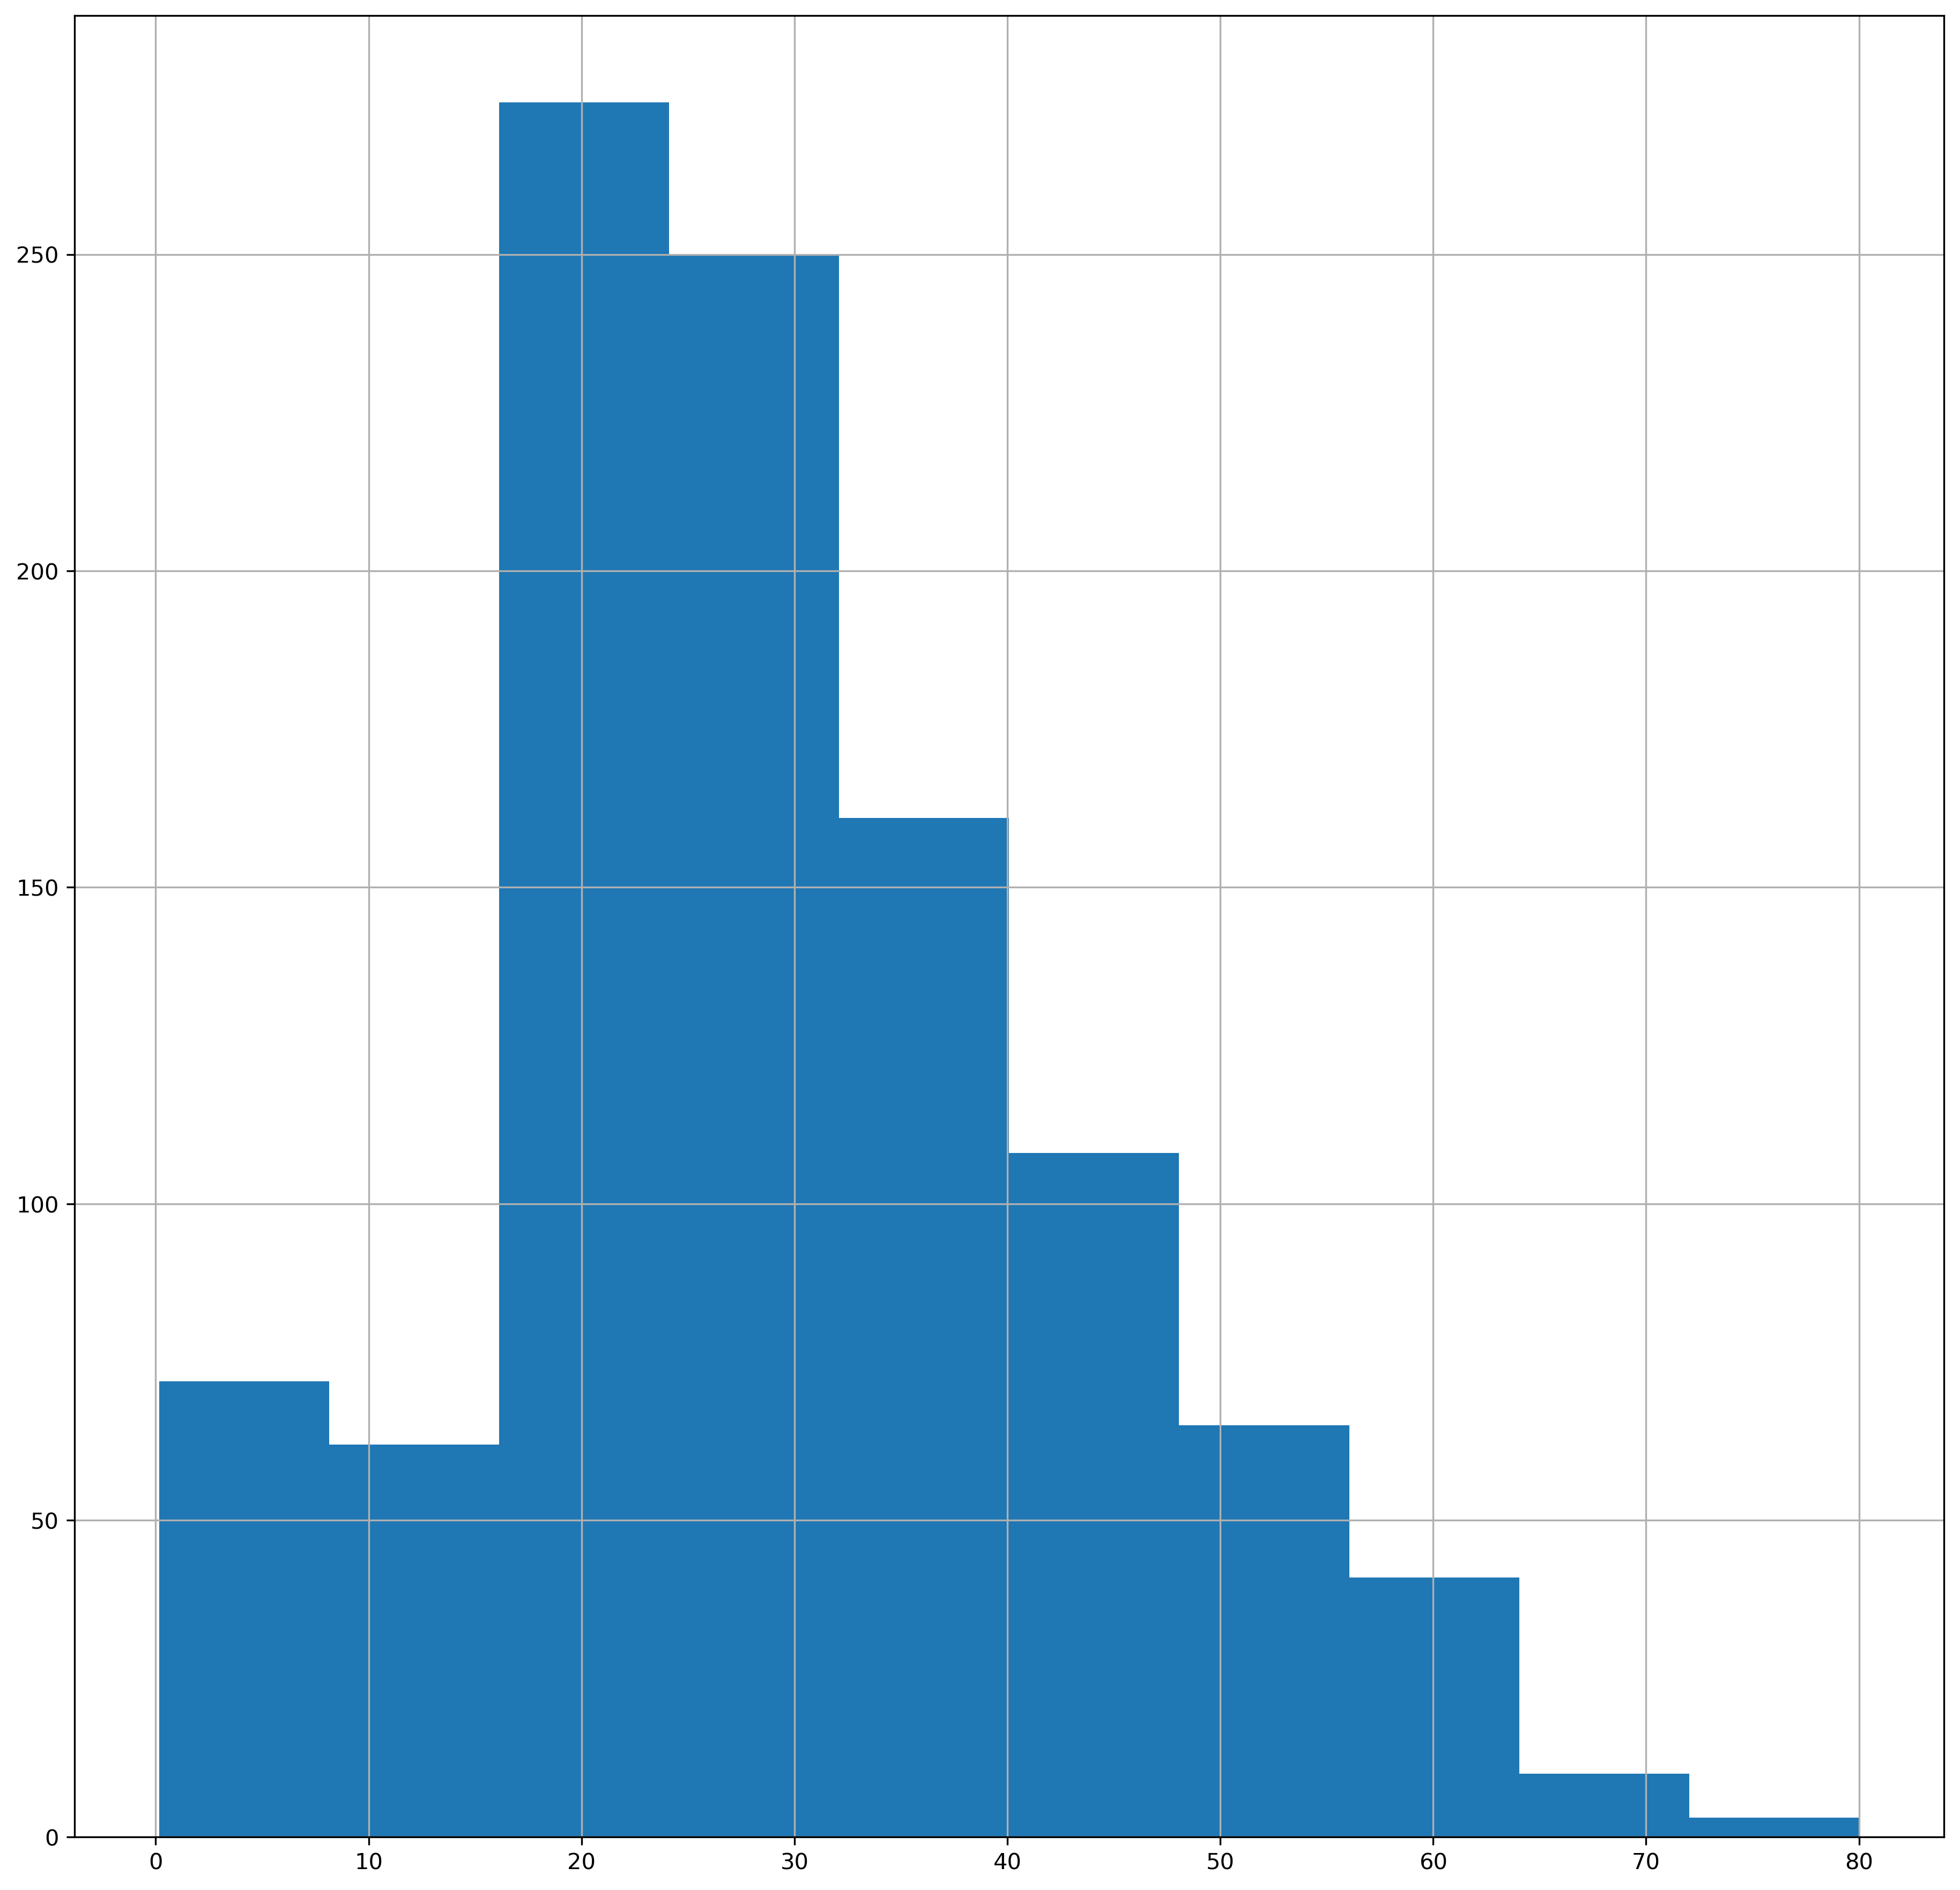

In [651]:
df.age.hist();

The most common ages refer to infants or young adults.

C:\Users\BASTIONMaxime\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\BASTIONMaxime\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


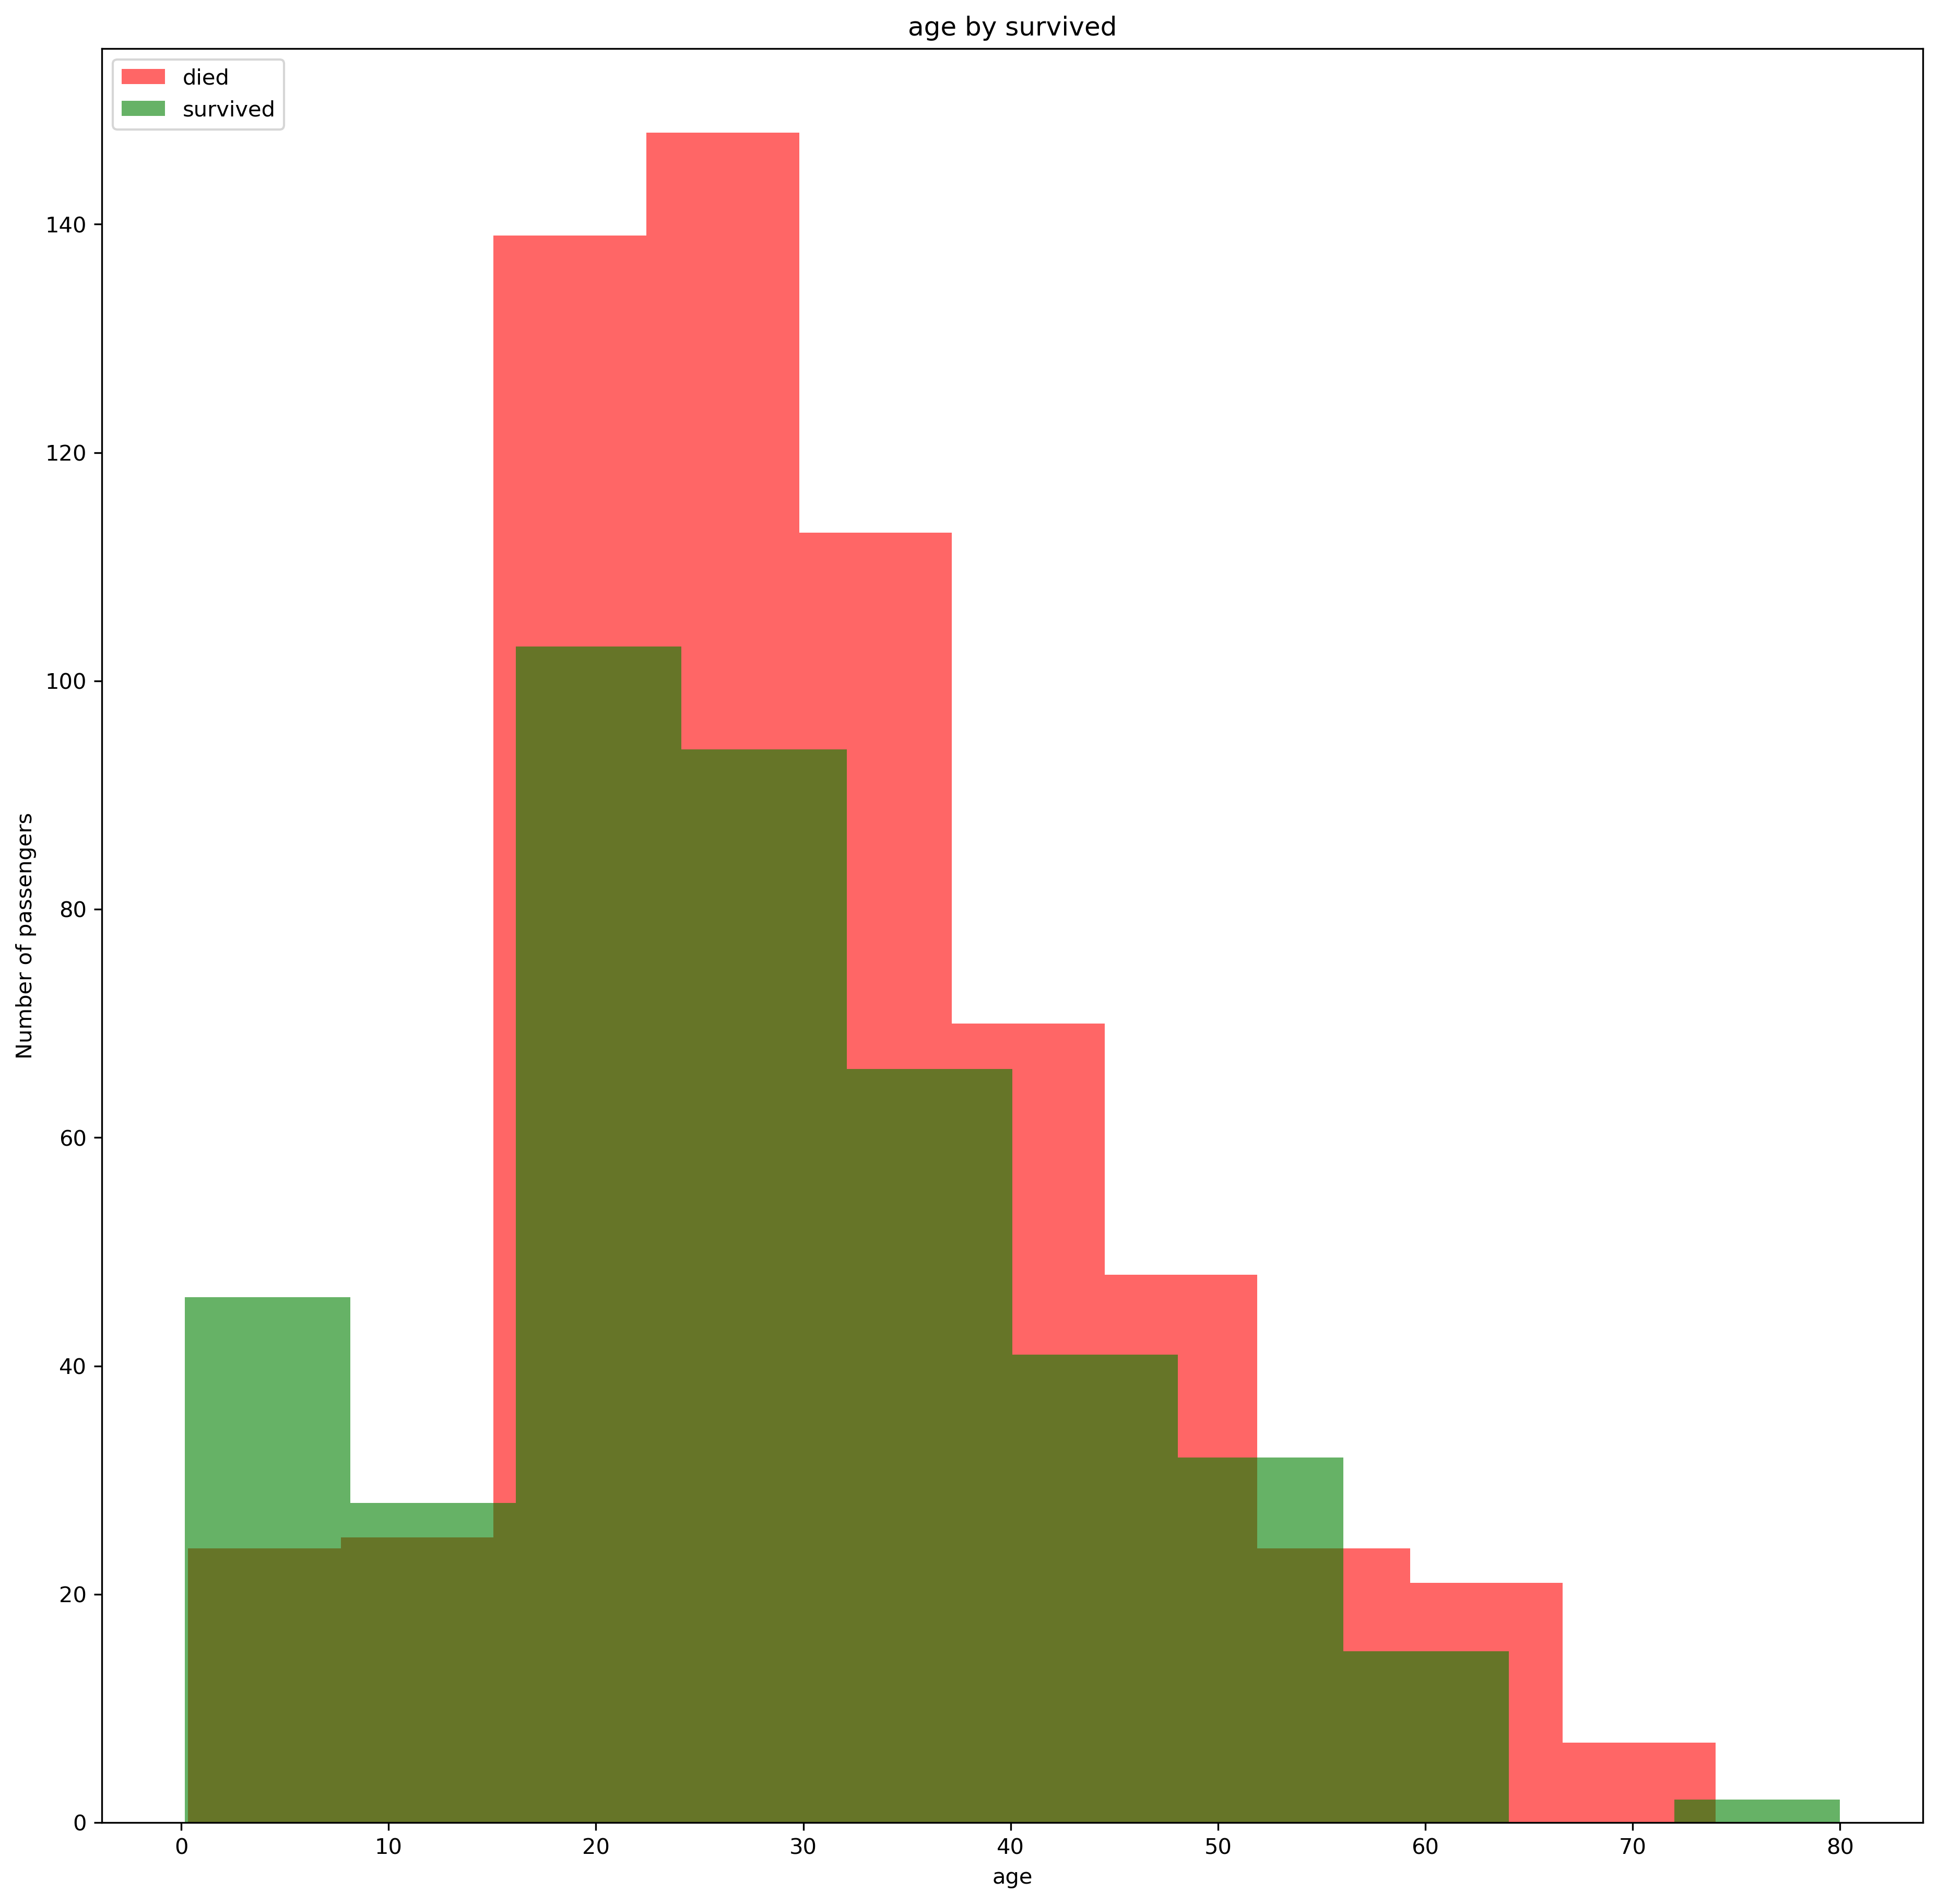

In [652]:
plot_distribution_by_target(feature="age")

The distribution of pclass for survivors is not drastically different from the distribution for those who died.

We do note that there are way more infants who survived than died. Let's explore this closer:

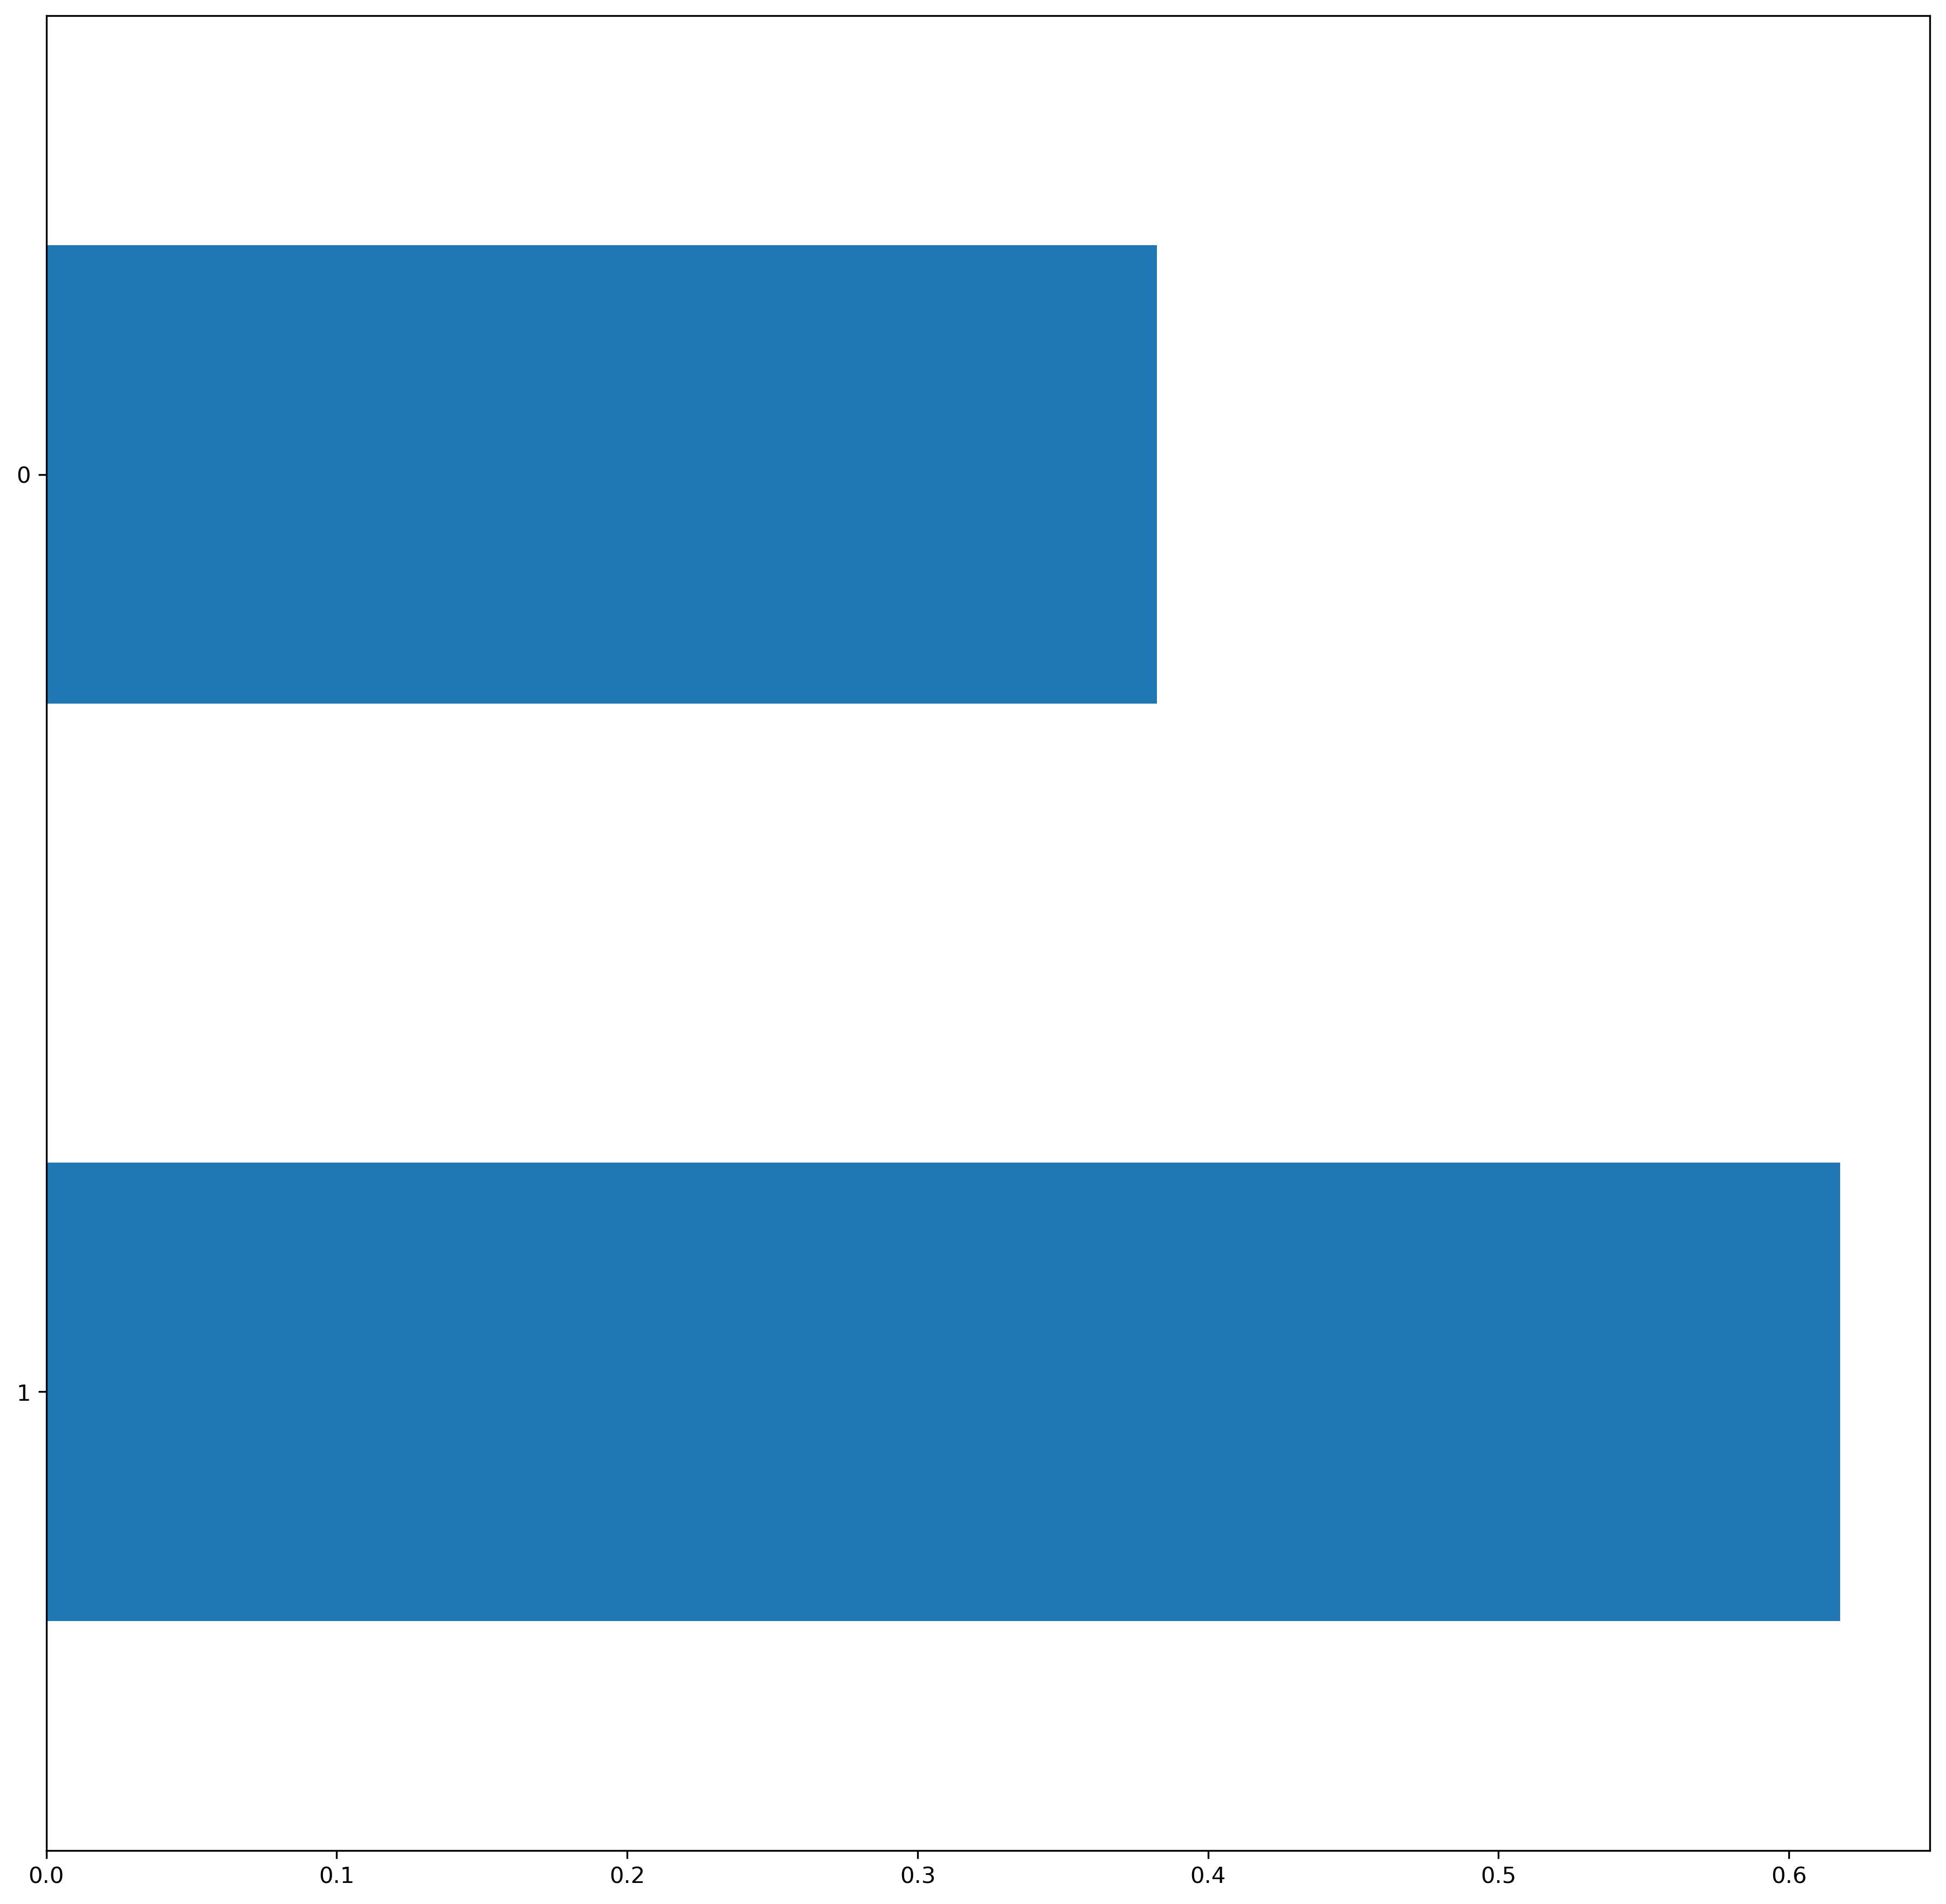

In [653]:
infants = df[df.age <= 2]
infants.survived.value_counts(normalize=True).plot.barh();

An infant has indeed a 62% change to survive.

In [654]:
n_nulls = df.age.isnull().sum()
n_nulls
n_nulls / len(df) * 100

263

20.091673032849503

There are 263 (20%) passengers for which we do not have an age value.
We will take a decision after the completion of the exploratory analysis.

#### * sibsp (Number of Siblings/Spouses Aboard)

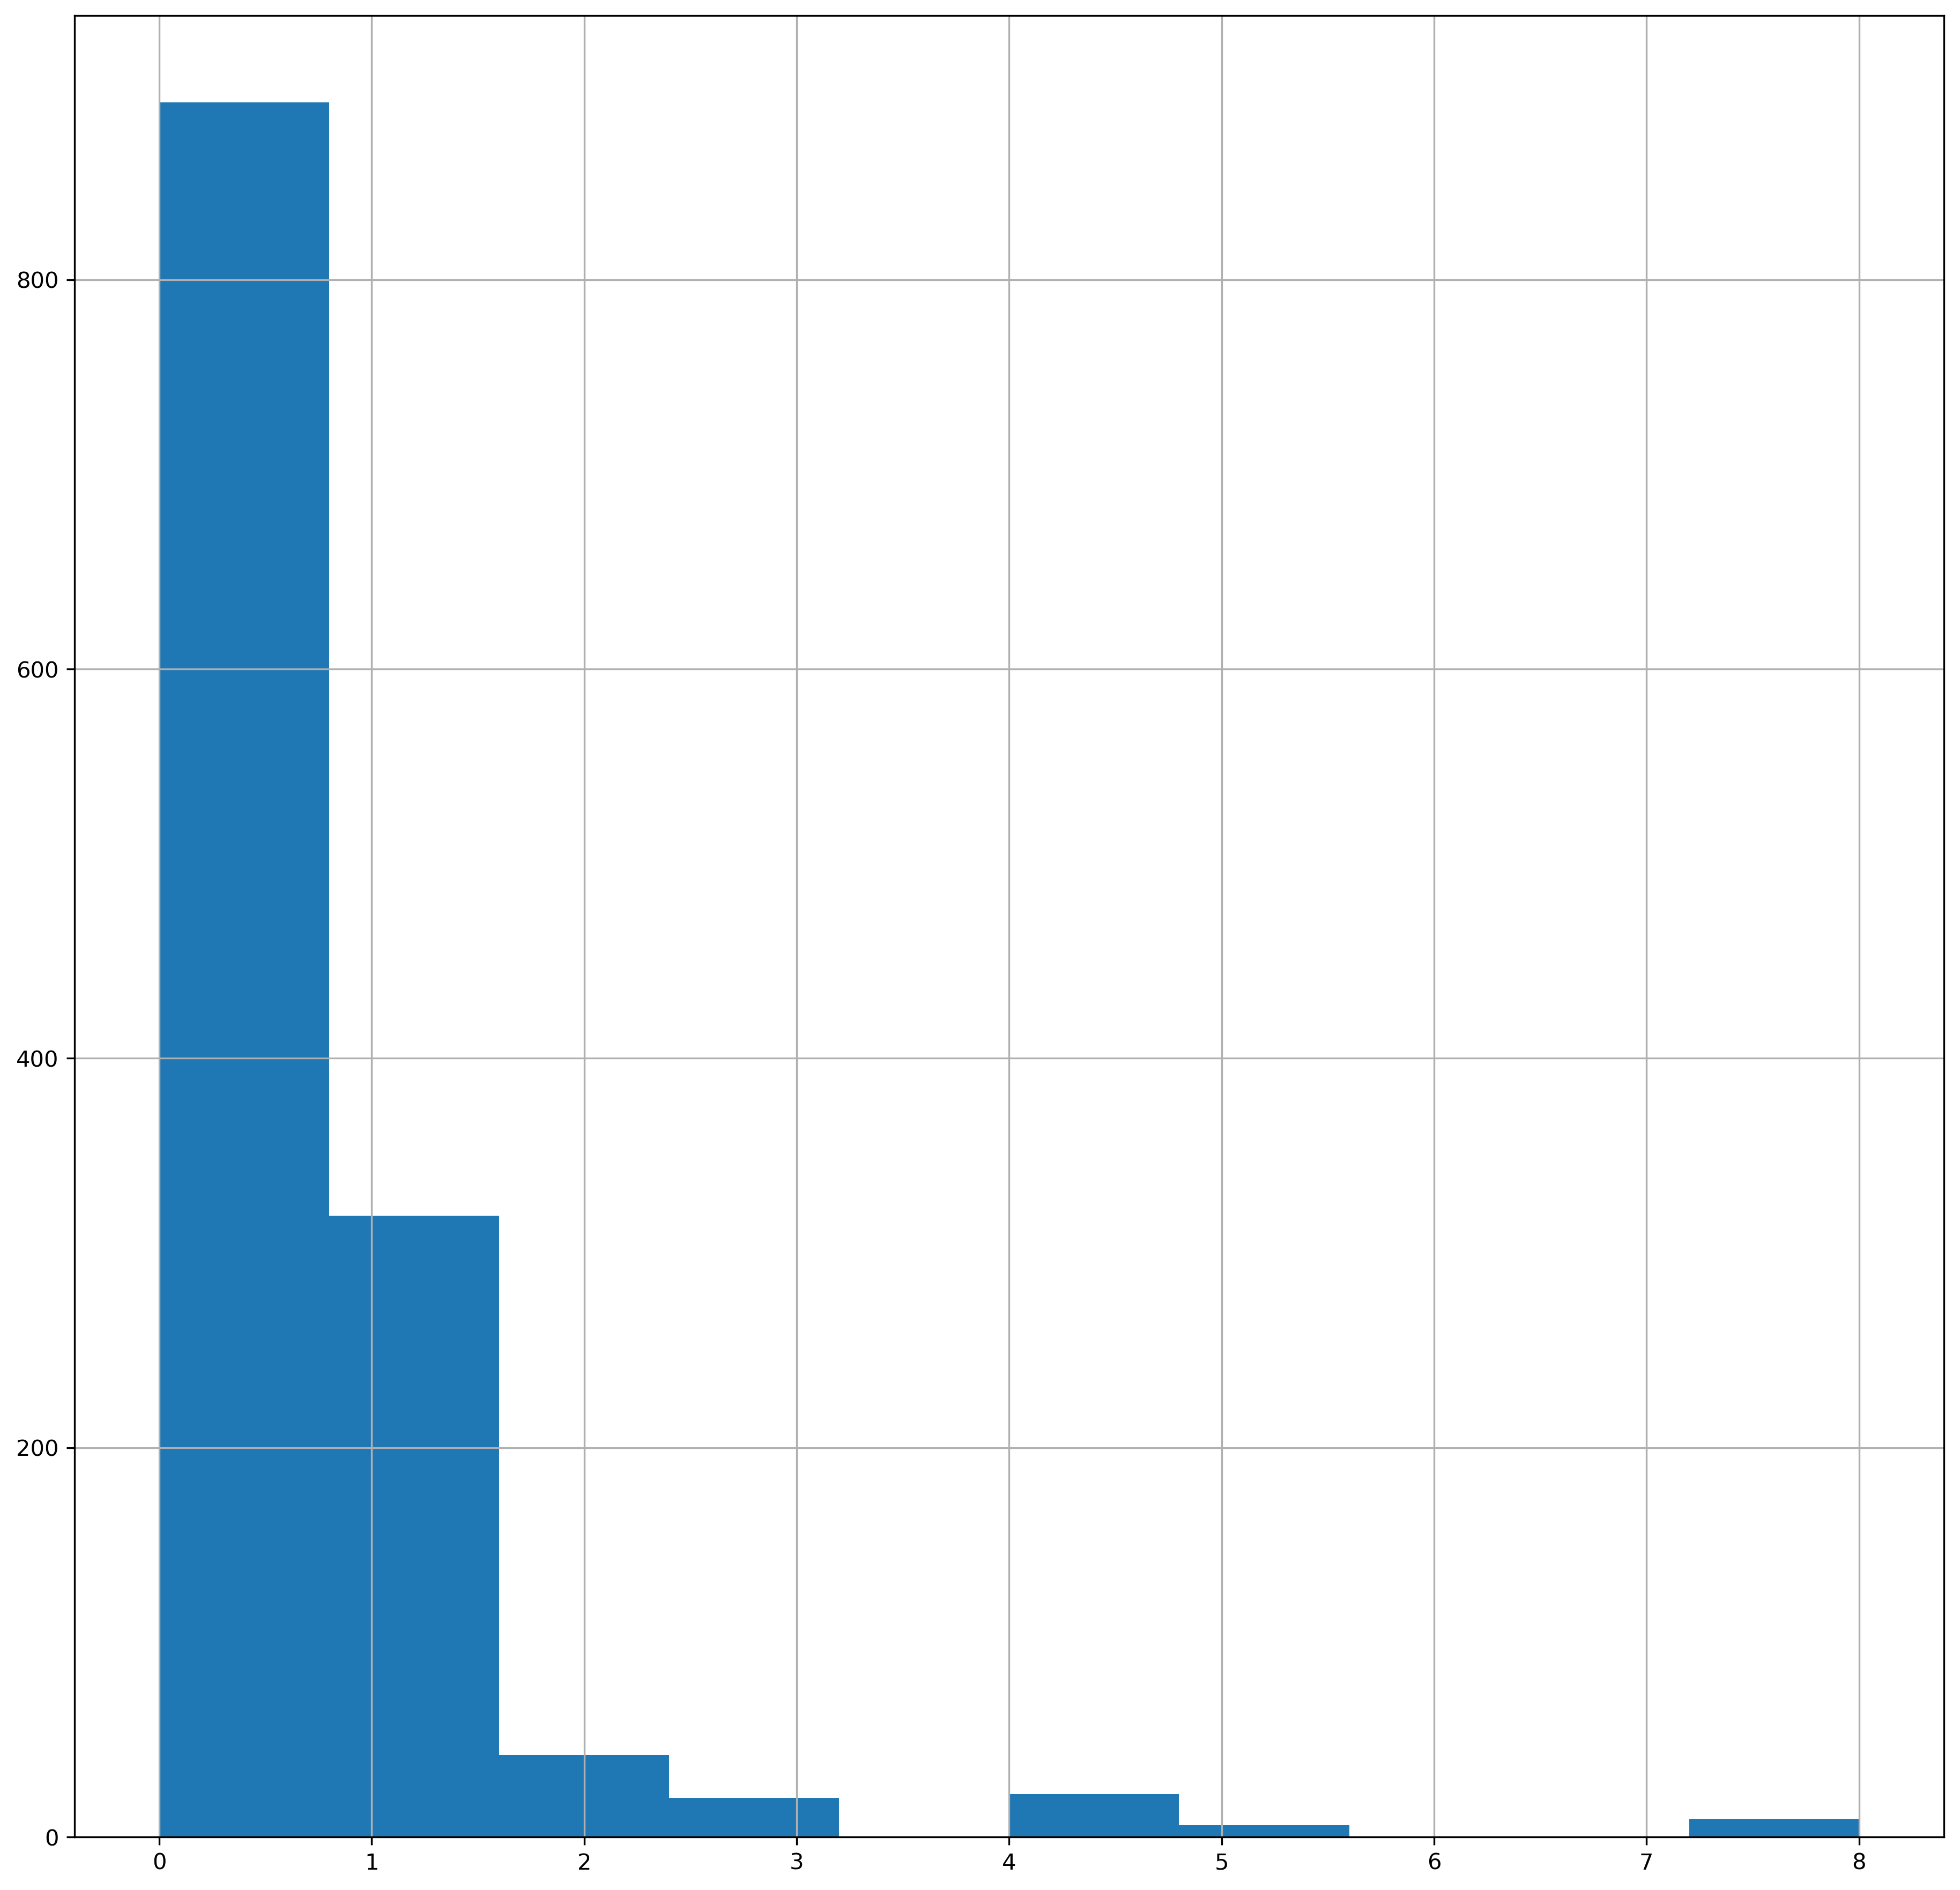

In [655]:
df.sibsp.hist();

Most passengers had no siblings or spouses aboard.

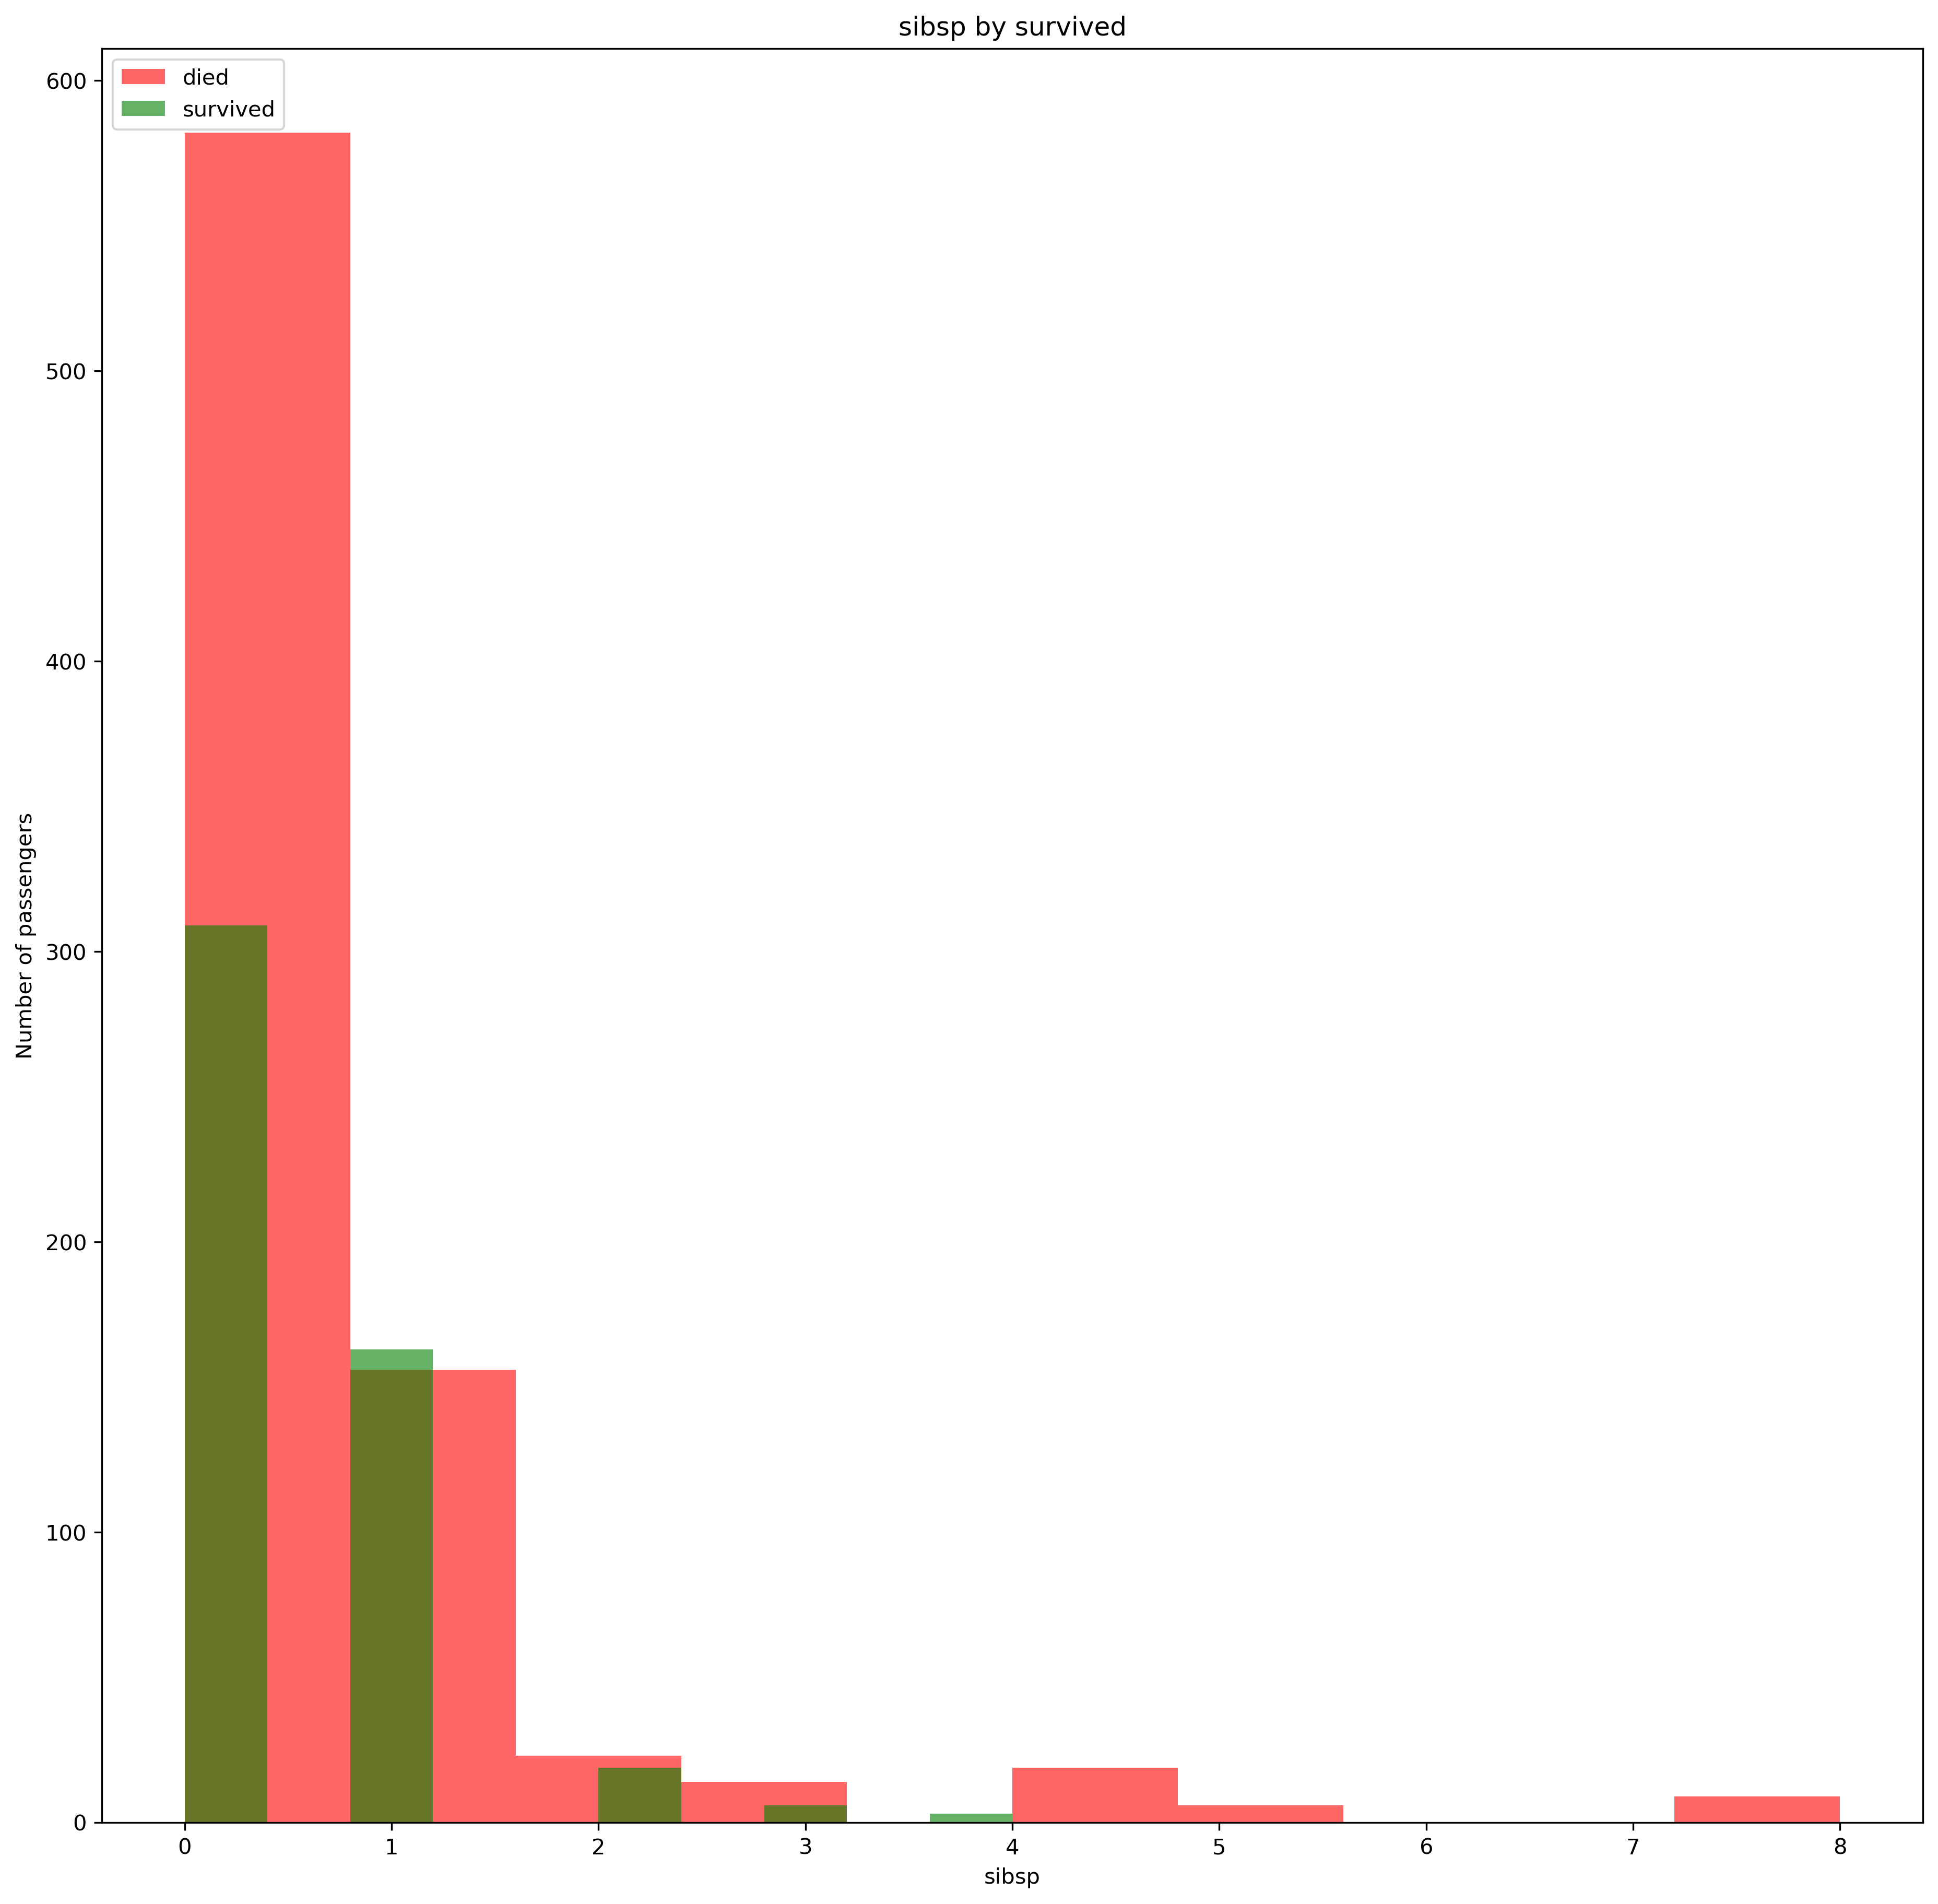

In [656]:
plot_distribution_by_target(feature="sibsp", stack=False)

It appears that passengers having siblings/spouses survived more.

In [657]:
df[df.sibsp > 0]["survived"].value_counts(normalize=True)
df[df.sibsp == 0]["survived"].value_counts(normalize=True)

0    0.543062
1    0.456938
Name: survived, dtype: float64

0    0.653199
1    0.346801
Name: survived, dtype: float64

Passengers with at least one sibling/spouse survived about 10% more.

In [658]:
df.sibsp.isnull().sum()

0

There are no missing values.

#### * parch (Number of Parents/Children Aboard)

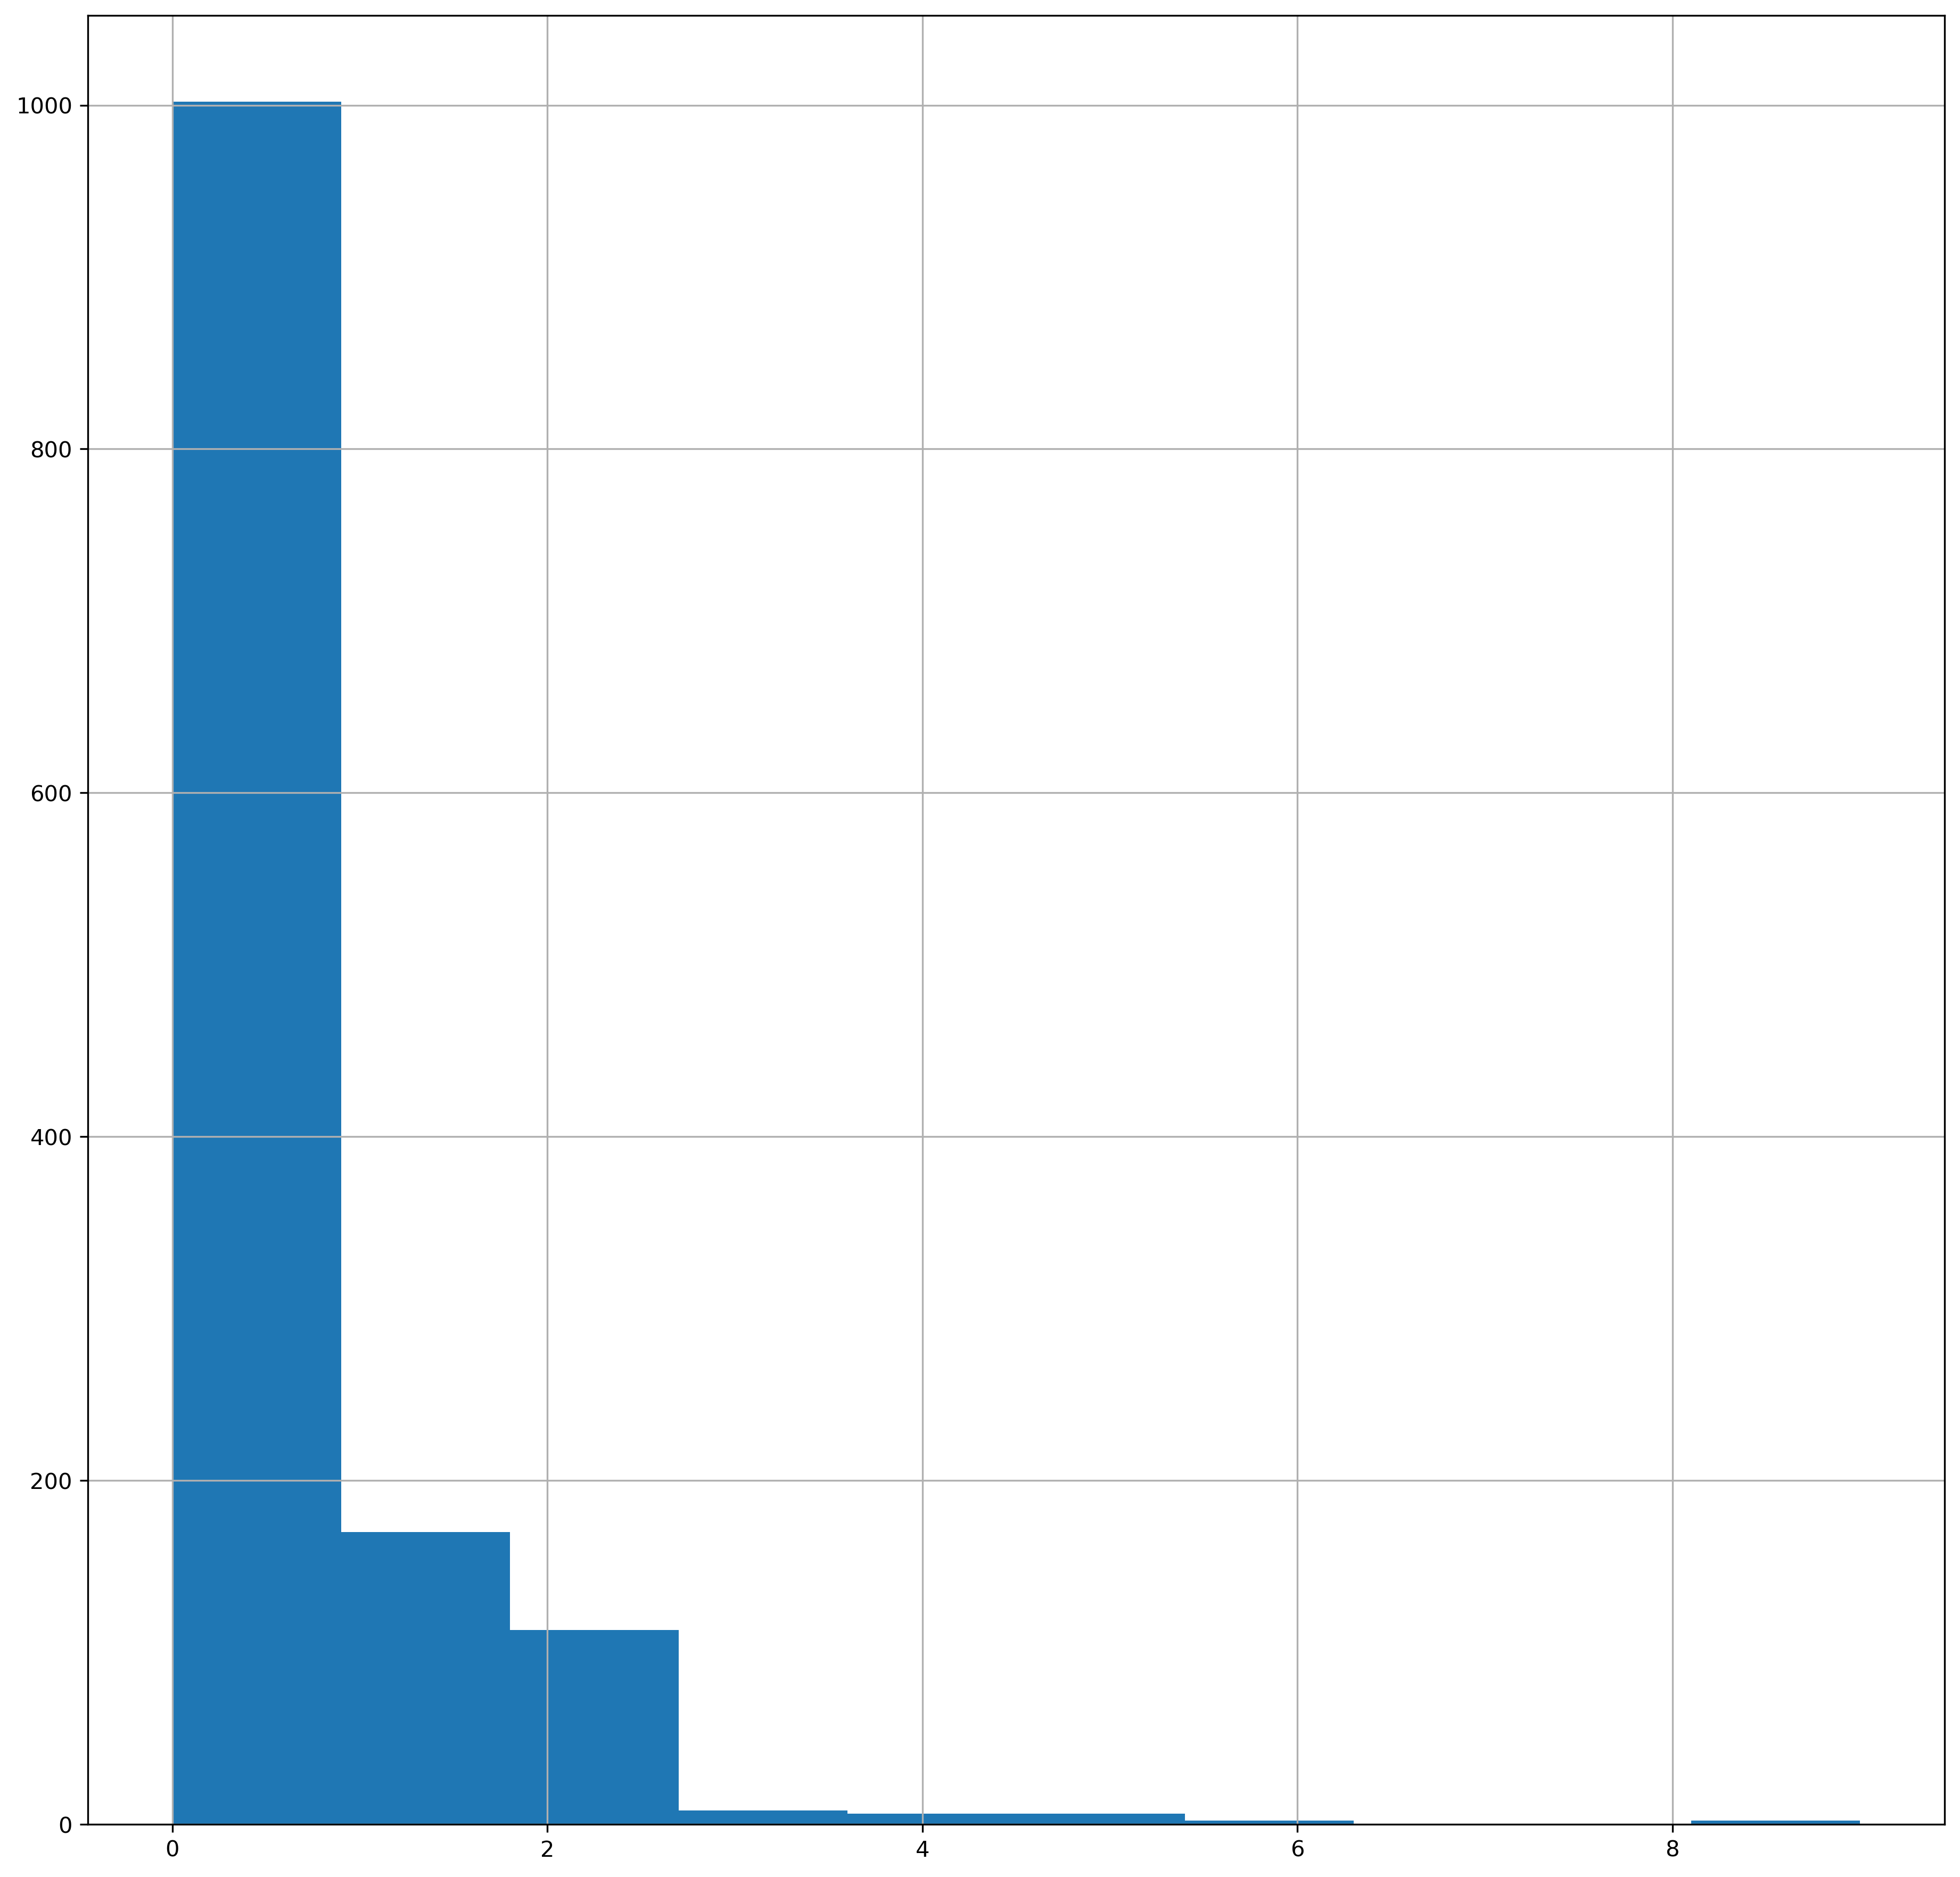

In [659]:
df.parch.hist();

Very right-skewed distribution: most passengers had 0 parents/children aboard.

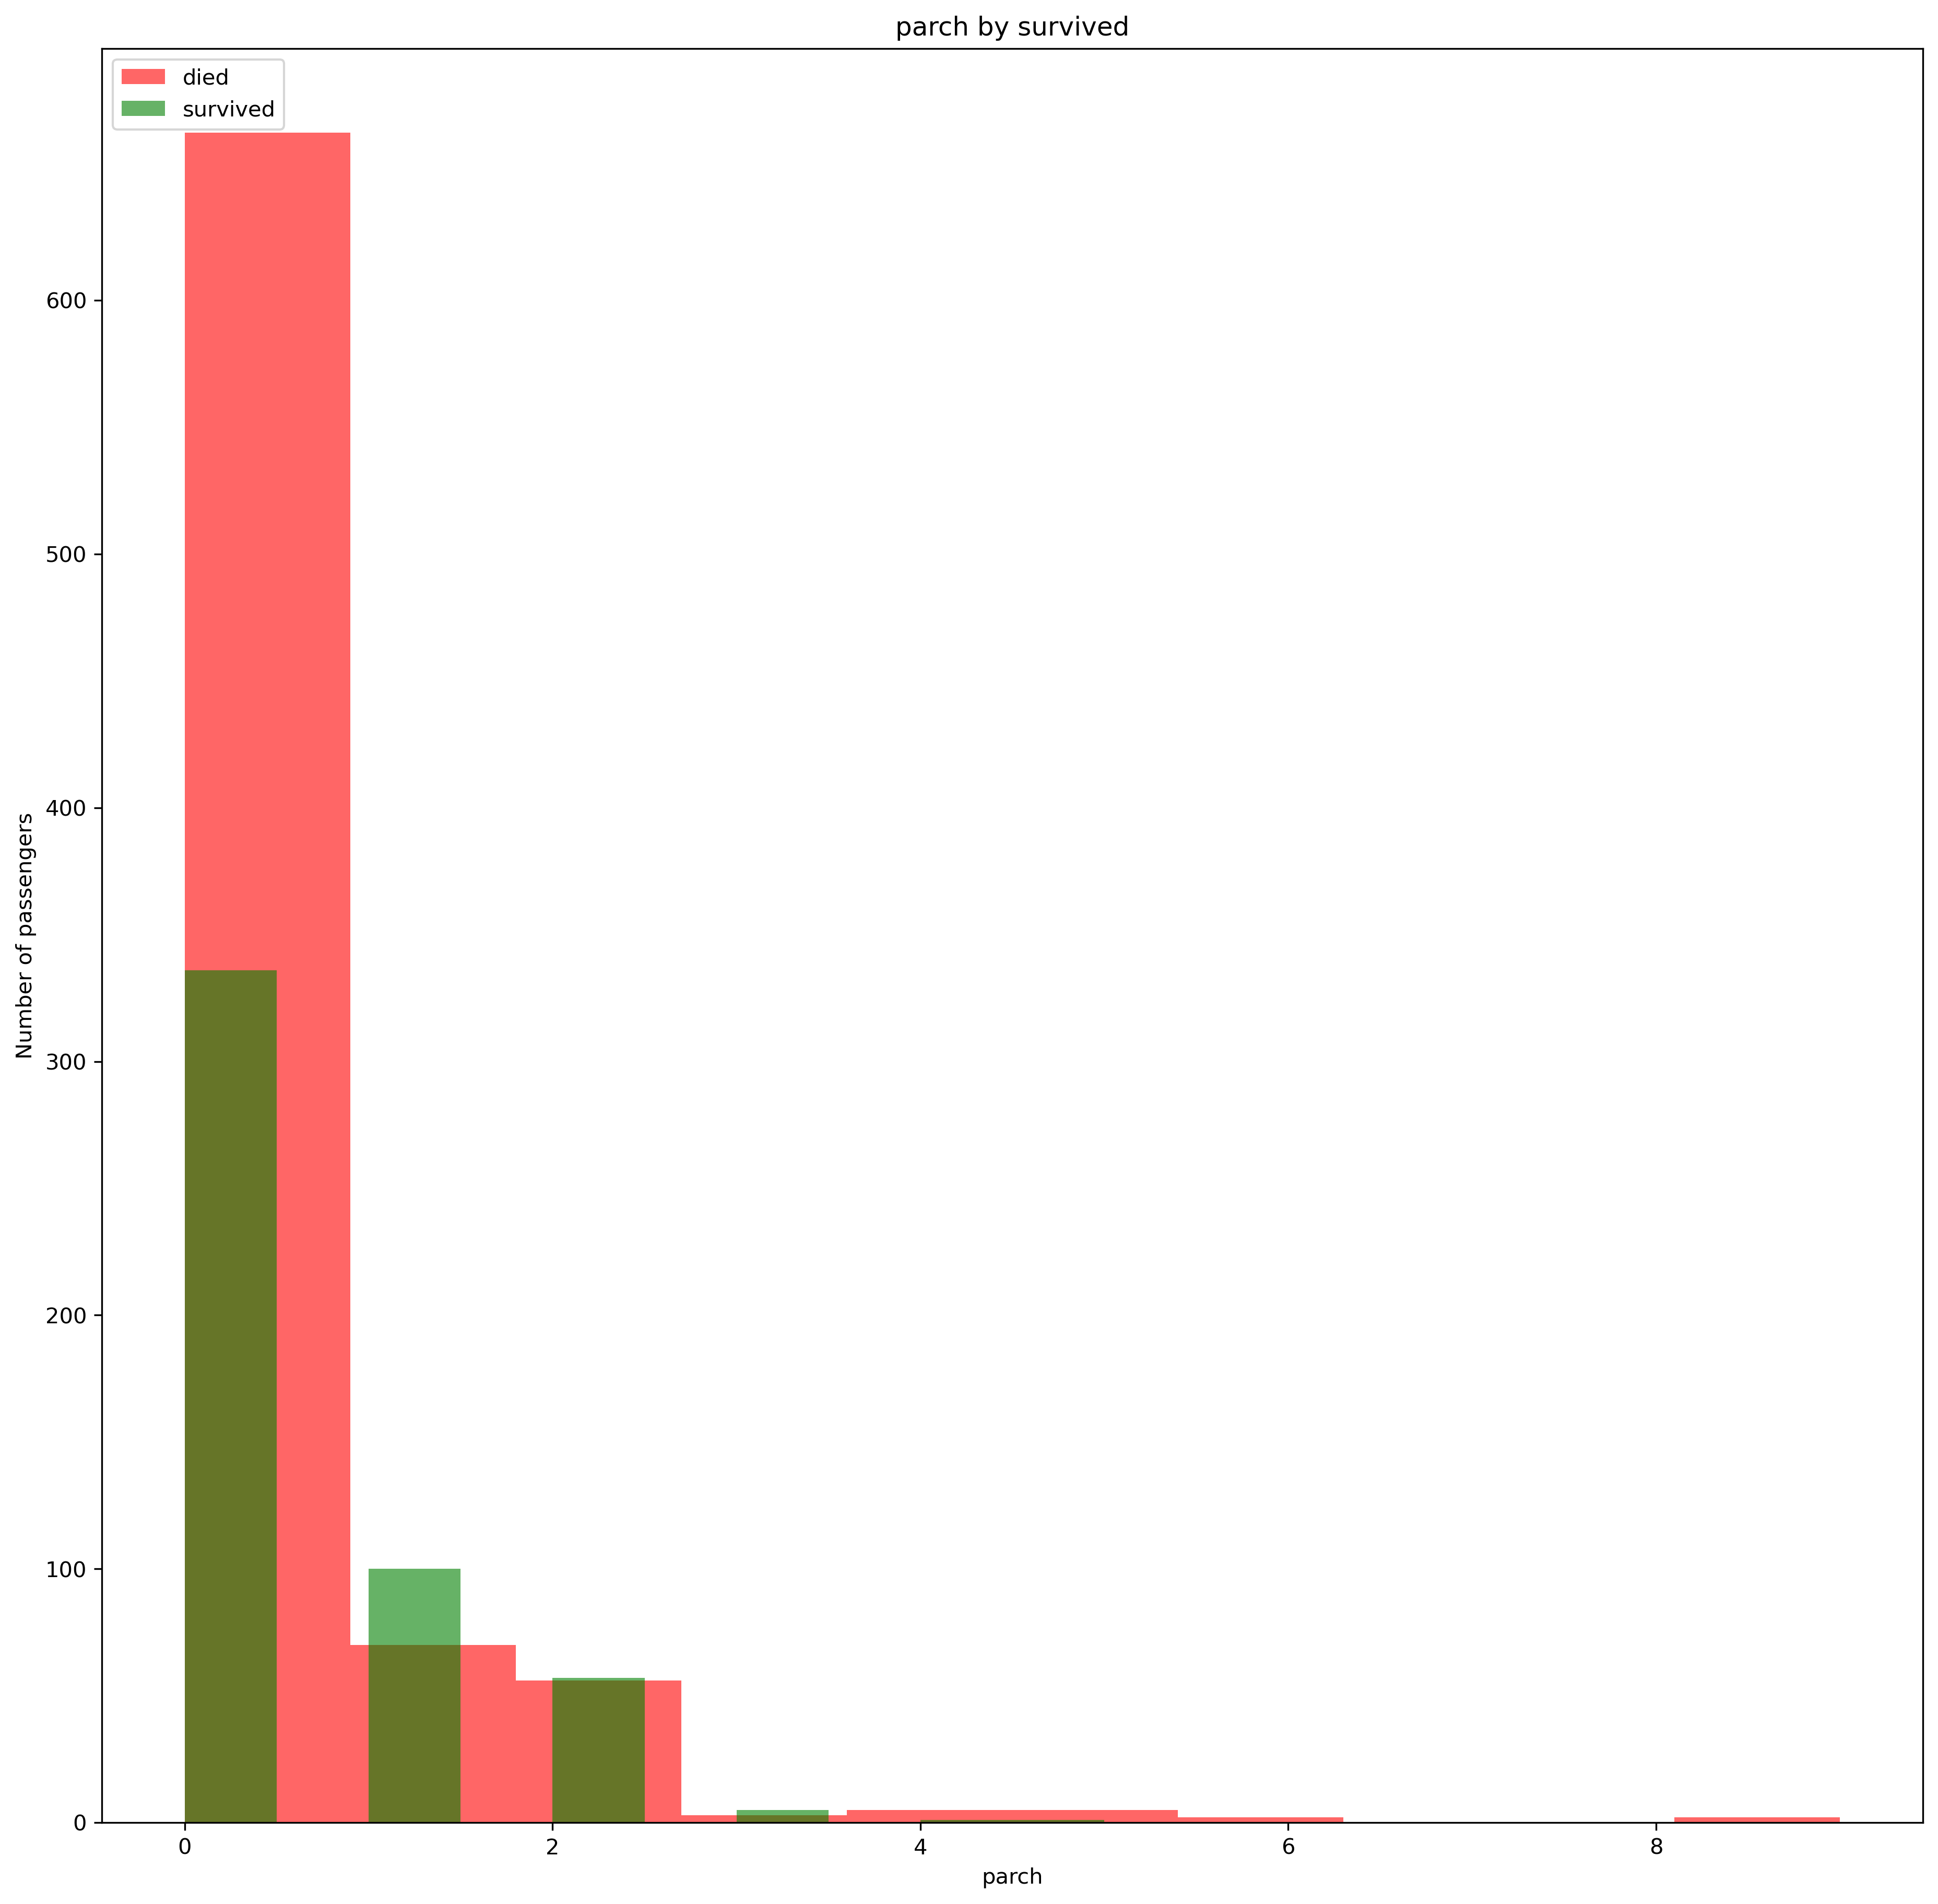

In [660]:
plot_distribution_by_target(feature="parch")

It appears that passengers having parents/children survived more.

In [661]:
df[df.parch > 0]["survived"].value_counts(normalize=True)
df[df.parch == 0]["survived"].value_counts(normalize=True)

1    0.534202
0    0.465798
Name: survived, dtype: float64

0    0.664671
1    0.335329
Name: survived, dtype: float64

Passengers having at least 1 parent/child survived 13% more.

In [662]:
df.parch.isnull().sum()

0

There are no missing values.

#### * ticket (Ticker number)

In [663]:
df.ticket.head(10)

0       24160
1      113781
2      113781
3      113781
4      113781
5       19952
6       13502
7      112050
8       11769
9    PC 17609
Name: ticket, dtype: object

In [664]:
df.ticket.describe()

count         1309
unique         929
top       CA. 2343
freq            11
Name: ticket, dtype: object

It is very like that the ticket number does not contain any meaningful information for our purpose.

In [665]:
df.ticket.isnull().sum()

0

There are no missing values.

#### * fare (Pre-1970 British Pounds (£))

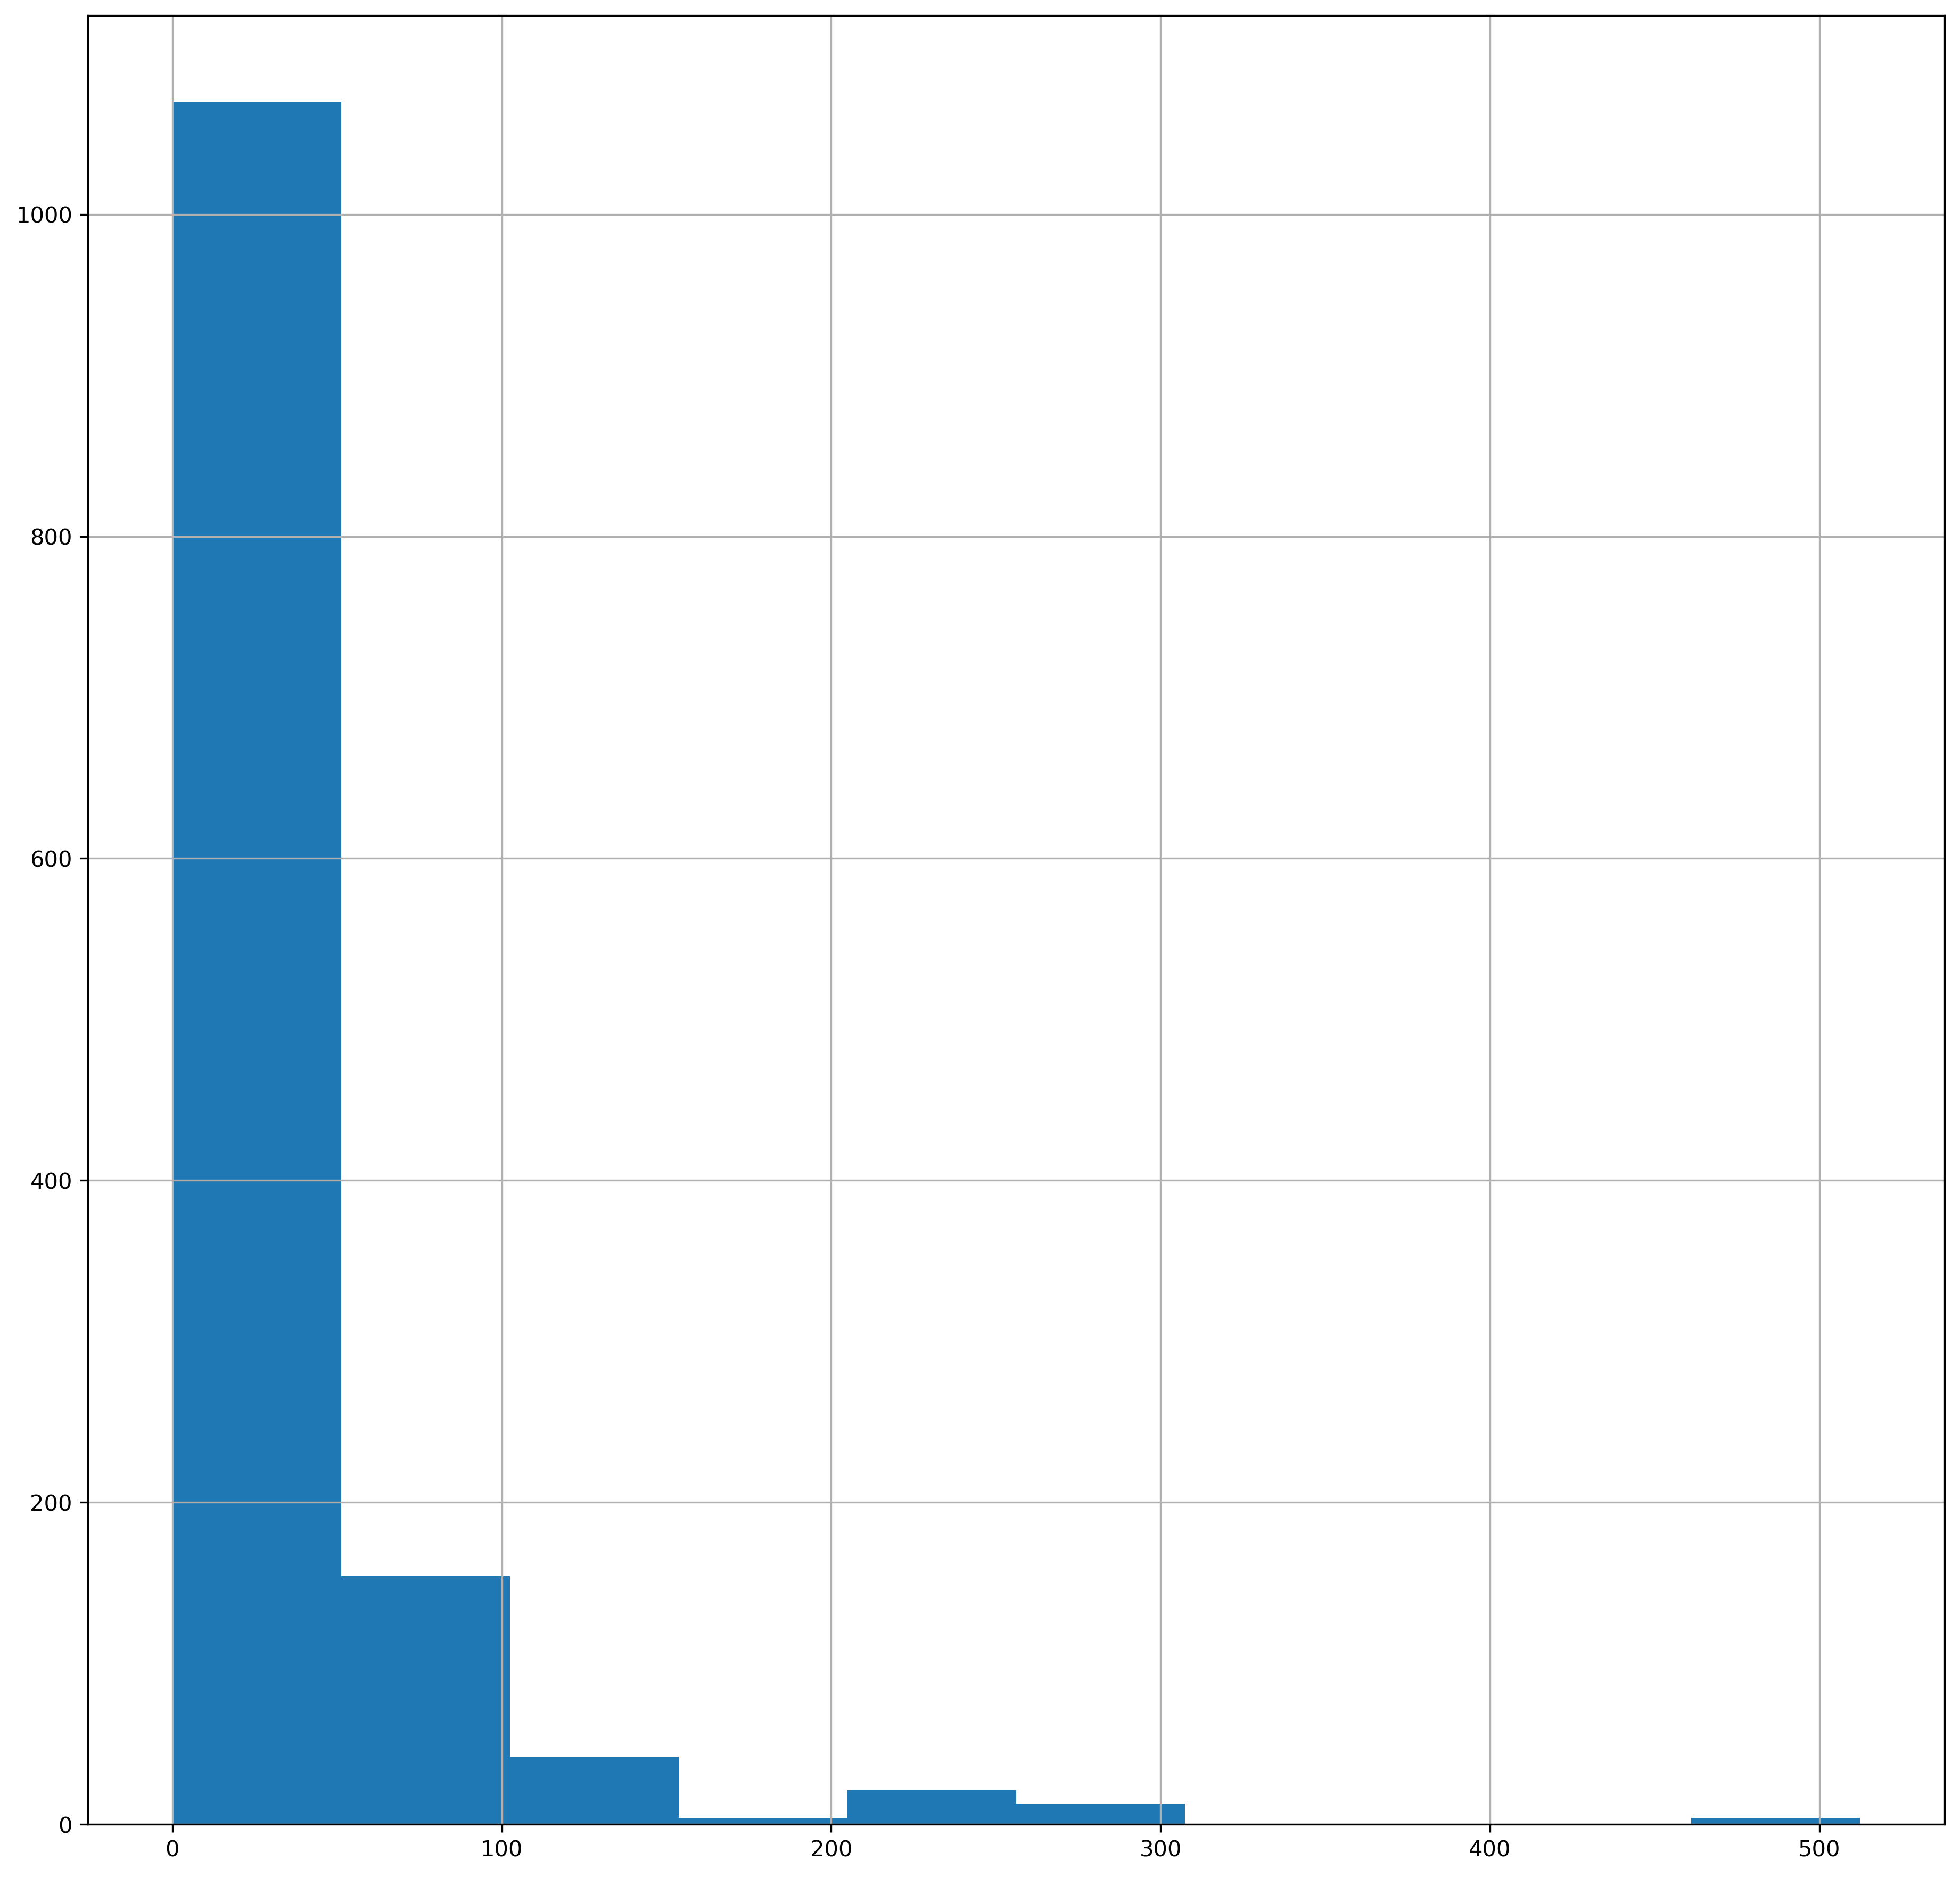

In [666]:
df.fare.hist();

Most passengers paid less than 100£.

A few passengers (outliers?) paid 5 times that amount.

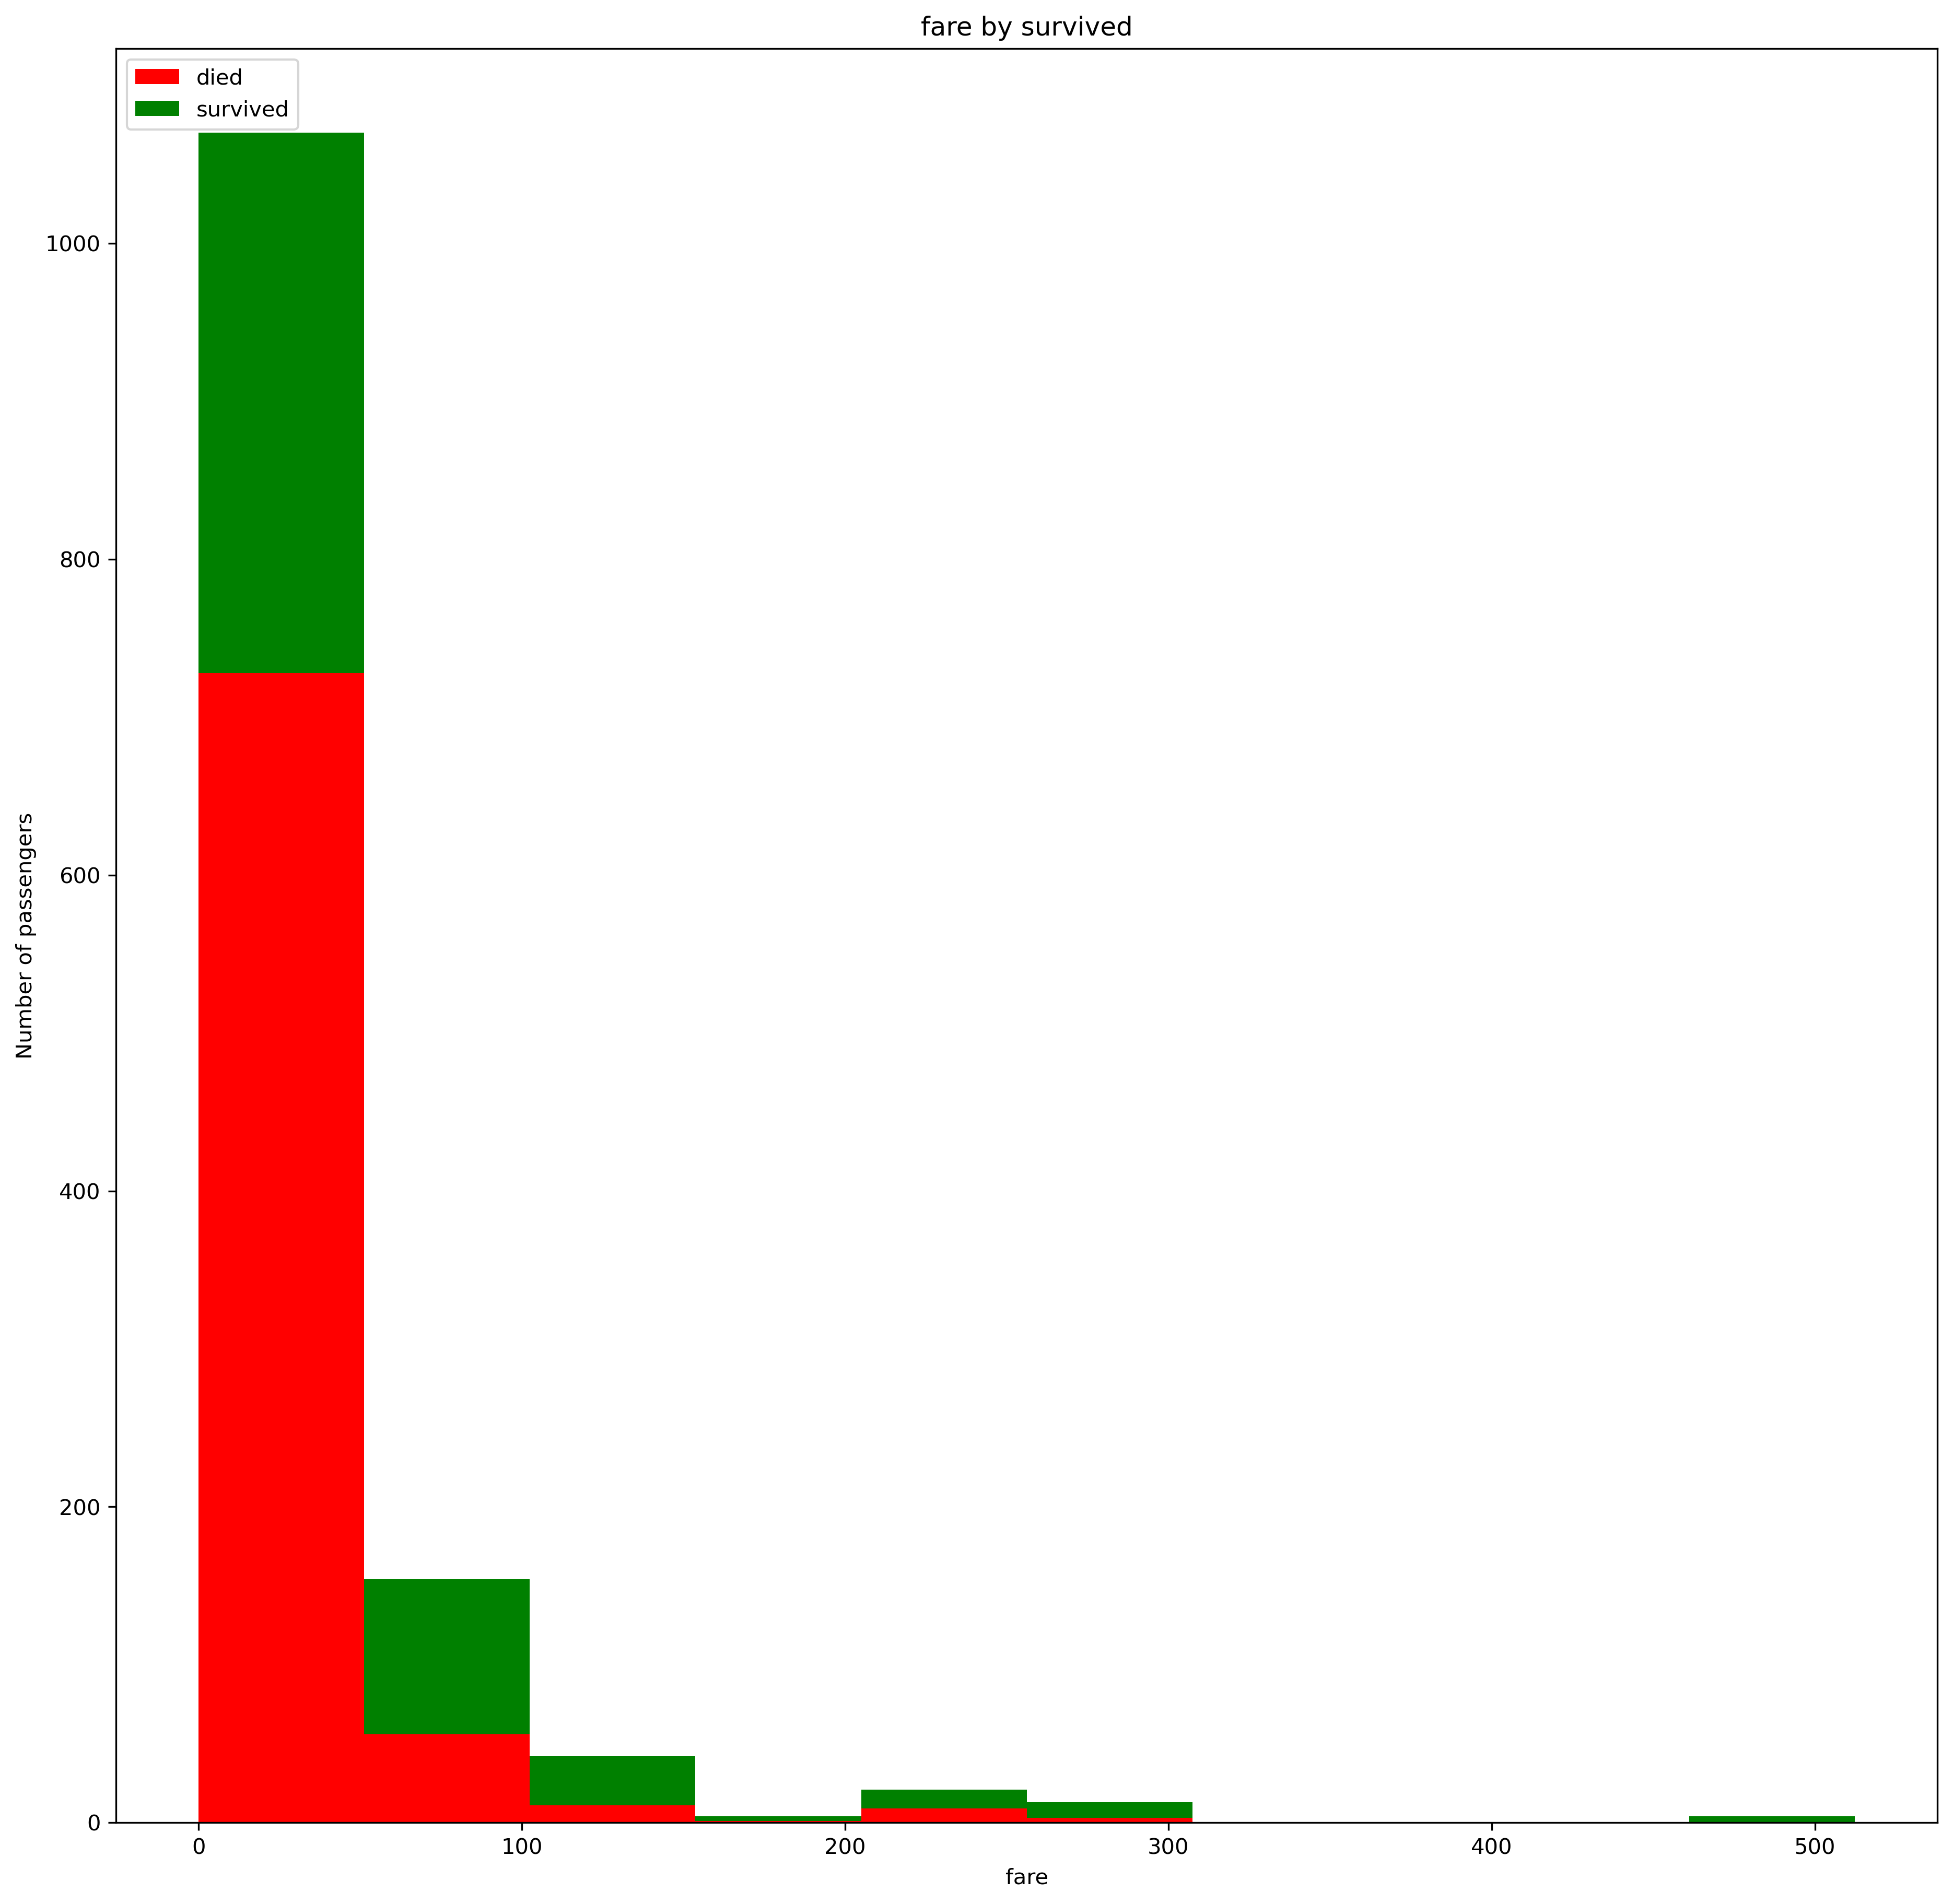

In [667]:
plot_distribution_by_target(feature="fare", stack=True)

It seems that passengers who paid 50£ or less have a lower survival rate than others.

In [668]:
df[df.fare <= 50]["survived"].value_counts(normalize=True)
df[df.fare > 50]["survived"].value_counts(normalize=True)

0    0.679775
1    0.320225
Name: survived, dtype: float64

1    0.658333
0    0.341667
Name: survived, dtype: float64

There does not seem to be any meaningful difference.

In [669]:
df.fare.isnull().sum()

1

There is one missing value, we could drop it without taking risks.

#### * cabin

In [670]:
df.cabin.head(10)

0         B5
1    C22 C26
2    C22 C26
3    C22 C26
4    C22 C26
5        E12
6         D7
7        A36
8       C101
9        NaN
Name: cabin, dtype: object

In [671]:
df.cabin.describe()

count             295
unique            186
top       C23 C25 C27
freq                6
Name: cabin, dtype: object

In [672]:
n_nulls = df.cabin.isnull().sum()
n_nulls
n_nulls / len(df) * 100

1014

77.46371275783041

It is unlikely that we can extract meaningful information without a lot of effort, and most of the values are missing, so we will ignore this variable.

#### * embarked (Port of Embarkation C = Cherbourg; Q = Queenstown; S = Southampton)

In [673]:
df.embarked.head()

0    S
1    S
2    S
3    S
4    S
Name: embarked, dtype: object

In [674]:
df.embarked.describe()

count     1307
unique       3
top          S
freq       914
Name: embarked, dtype: object

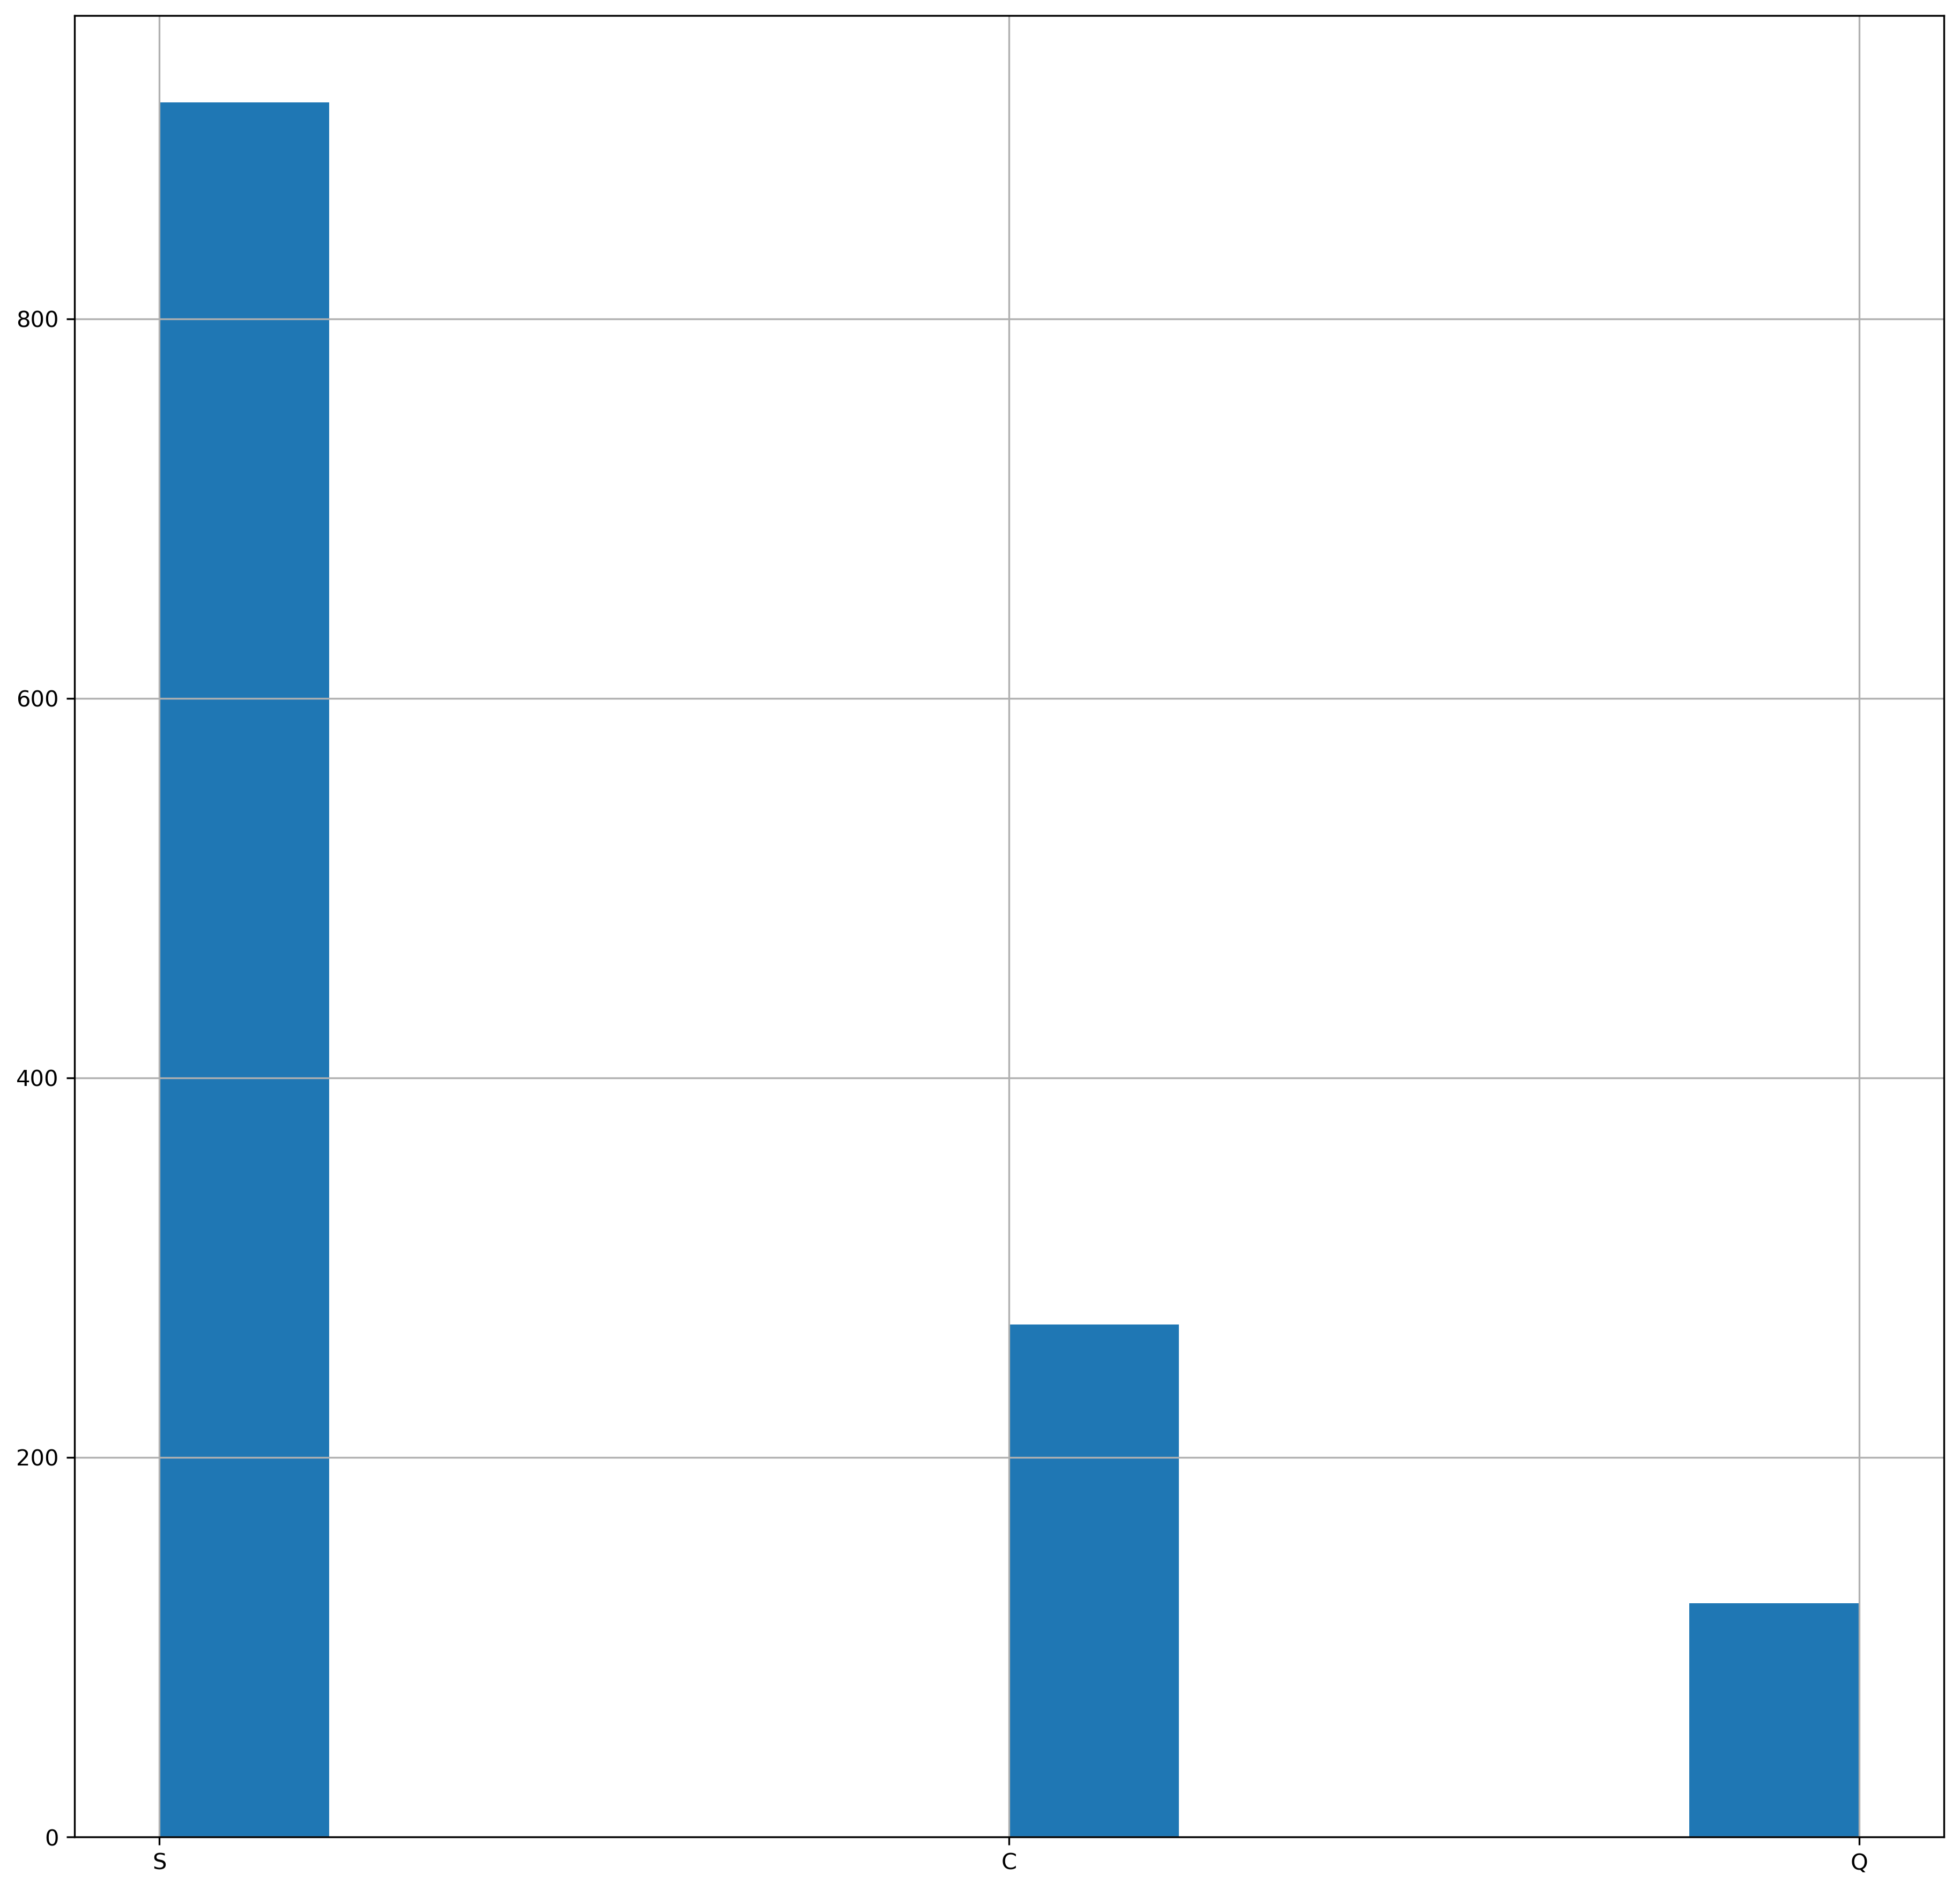

In [675]:
df.embarked.hist();

In [676]:
df.embarked.value_counts(normalize=True)

S    0.699311
C    0.206580
Q    0.094109
Name: embarked, dtype: float64

Most passengers embarked at Southampton, and twice as many passengers embarked at Cherbourg than Queenstown.

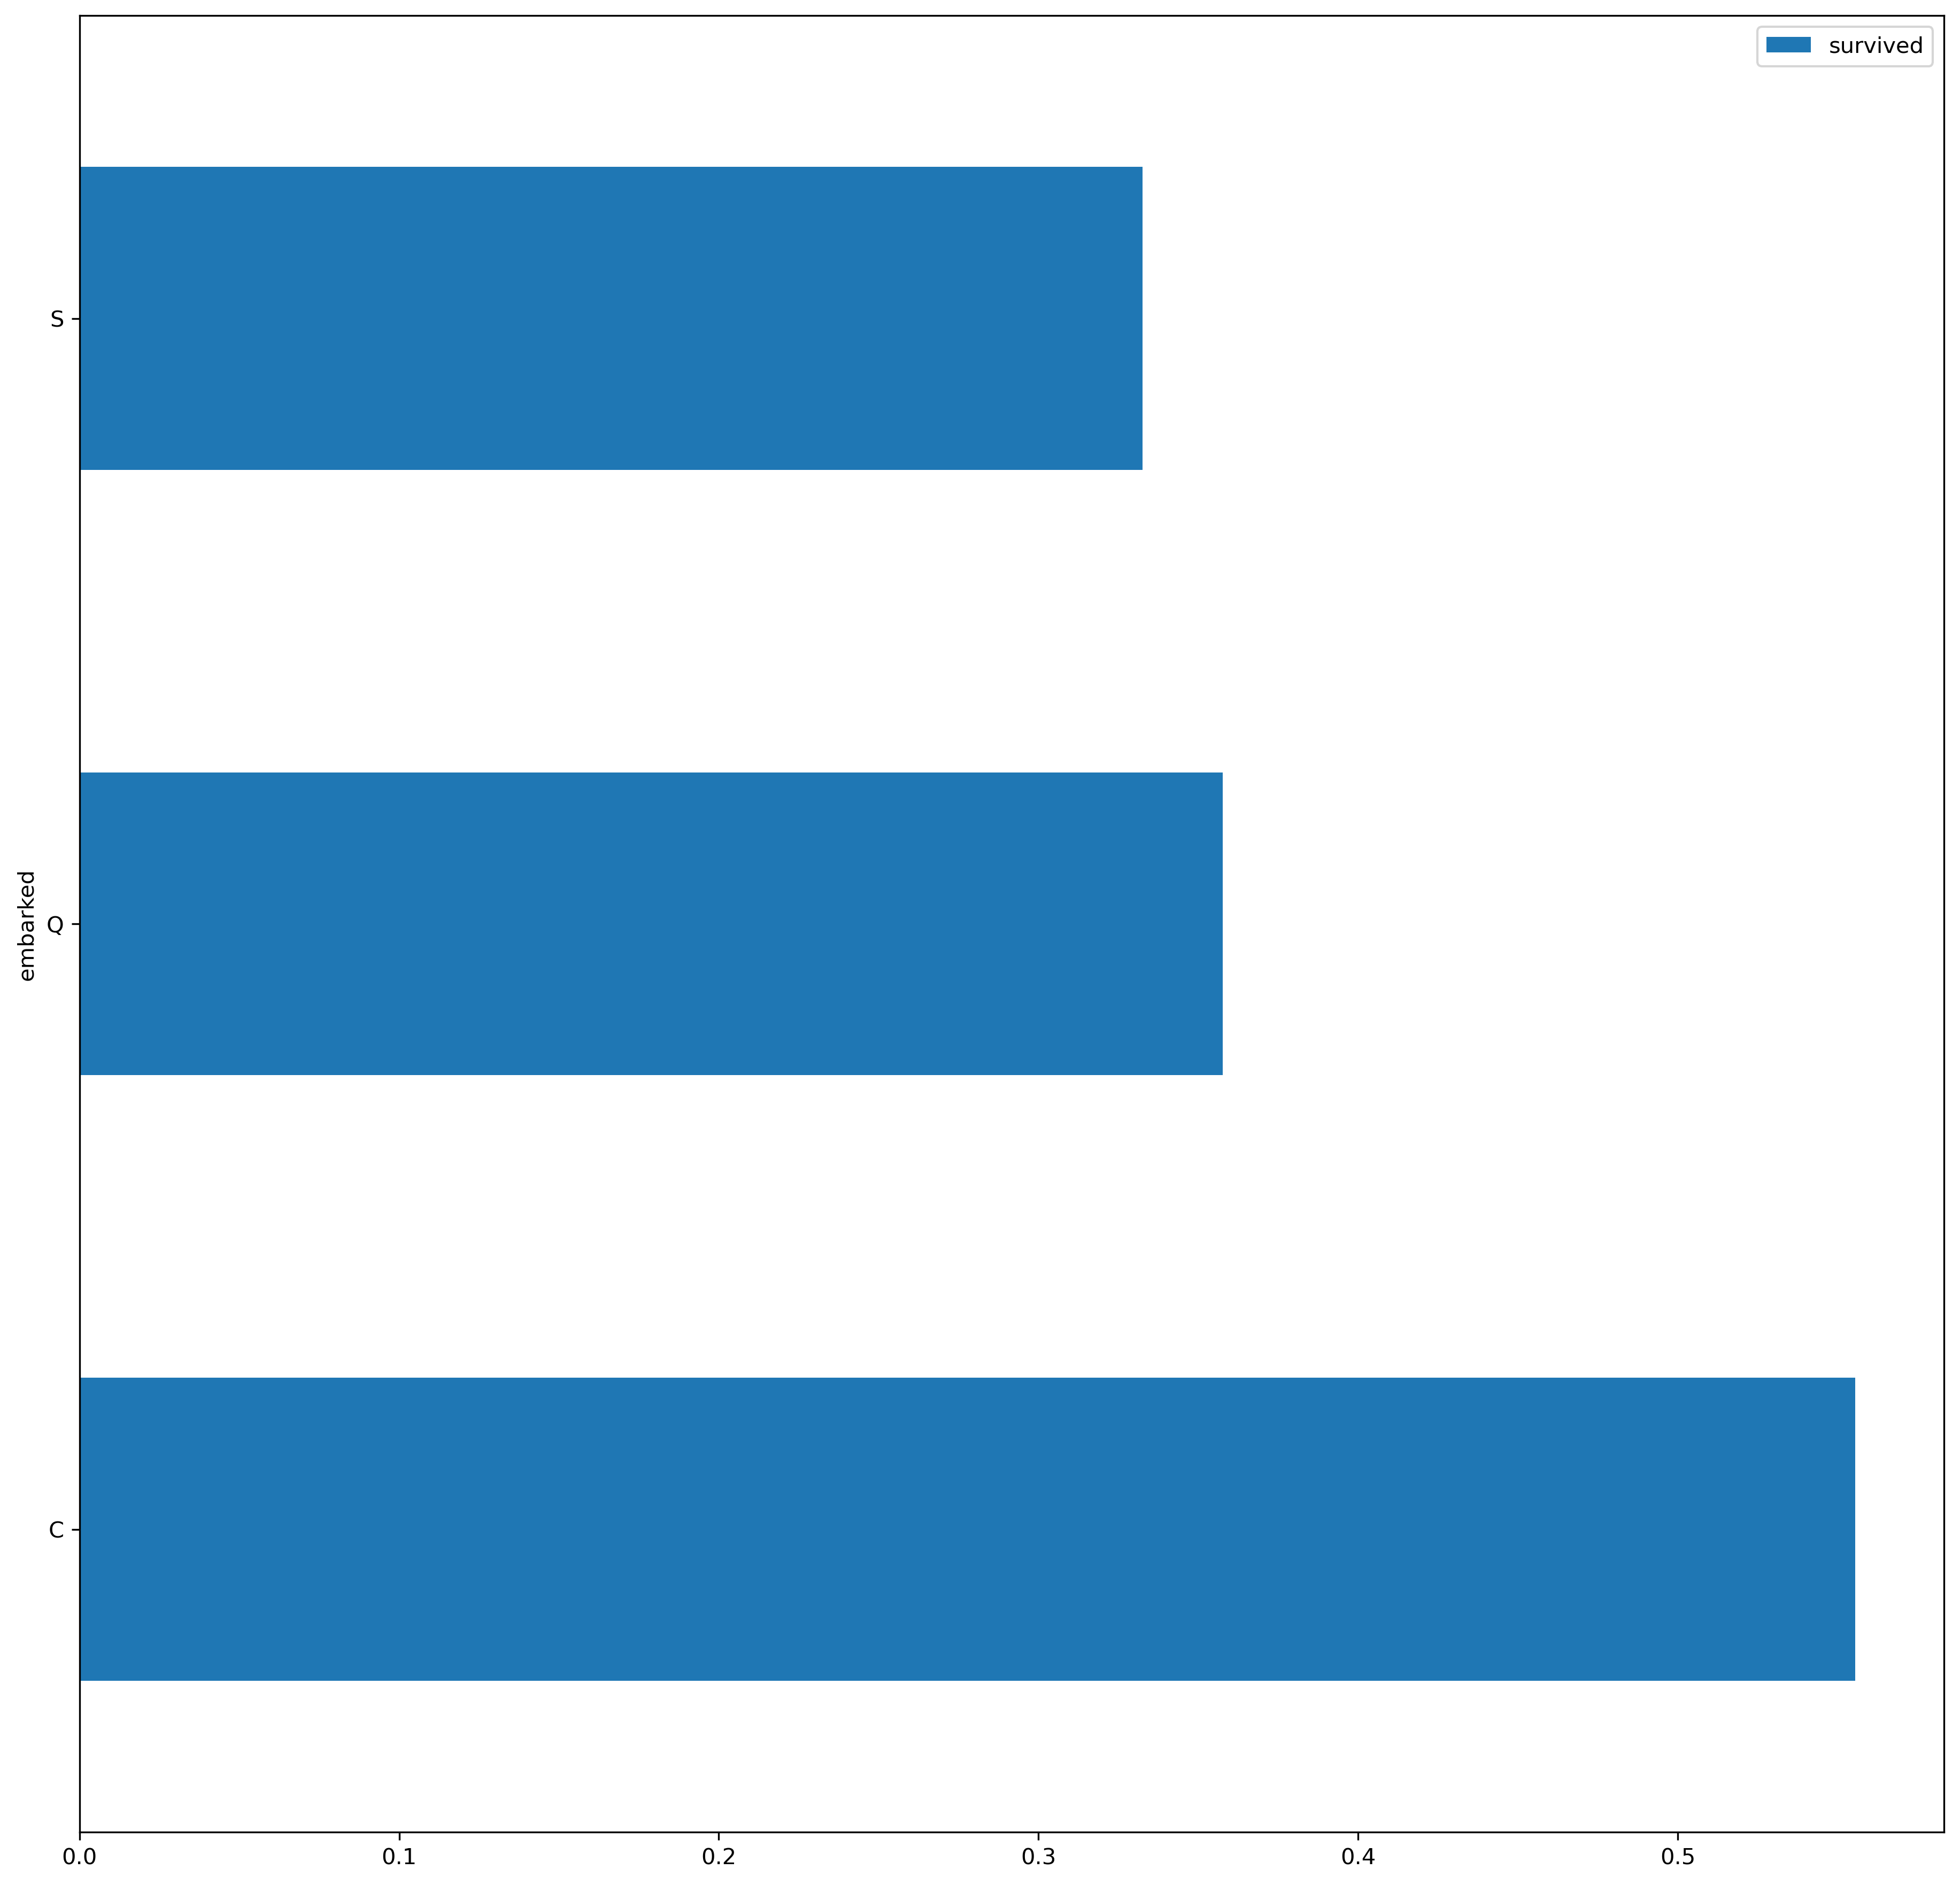

In [677]:
df[["embarked", "survived"]].groupby("embarked").mean().plot.barh()

In [678]:
df[["embarked", "survived"]].groupby("embarked").mean()

,survived
embarked,
C,0.555556
Q,0.357724
S,0.332604


Passengers who embarked at Cherbourg survived about 20% more than others.

In [679]:
df.embarked.isnull().sum()

2

Only 2 values are missing, we could drop these passengers without taking risks.

* #### home.dest (Home/Destination)

In [680]:
df["home.dest"].head()

0                       St Louis, MO
1    Montreal, PQ / Chesterville, ON
2    Montreal, PQ / Chesterville, ON
3    Montreal, PQ / Chesterville, ON
4    Montreal, PQ / Chesterville, ON
Name: home.dest, dtype: object

In [681]:
df["home.dest"].describe()

count              745
unique             369
top       New York, NY
freq                64
Name: home.dest, dtype: object

In [682]:
df["home.dest"].value_counts()

New York, NY                        64
London                              14
Montreal, PQ                        10
Paris, France                        9
Cornwall / Akron, OH                 9
                                    ..
Austria Niagara Falls, NY            1
England / Detroit, MI                1
St Ives, Cornwall / Houghton, MI     1
London Skanteales, NY                1
Denver, CO                           1
Name: home.dest, Length: 369, dtype: int64

We do not have enough observations per destination to make this variable useful. We will drop it.

### What we learned
After completing the data exploration, we note that:
* We should drop home.dest and cabin
* We should drop name but explore creating features with it
* sibsp and parch have a similar pattern: not being alone is good for your survival. We could group these variables into a new feature 'is_alone'

<a id="dataCleaning"><a/>

## Data Cleaning

In [683]:
df = df.drop(columns=["boat", "body", "ticket", "home.dest", "cabin"])

<a id="featureEngineering"><a/>

### Feature Engineering

* #### is_alone

In [684]:
df["is_alone"] = df.apply(lambda row: 1 if row["sibsp"] + row["parch"] == 0 else 0, axis=1)

In [685]:
df.groupby("is_alone").mean()["survived"]

is_alone
0    0.502890
1    0.302532
Name: survived, dtype: float64

In [686]:
df[["is_alone", "survived"]].corr()

,is_alone,survived
is_alone,1.000000,-0.201719
survived,-0.201719,1.000000


There is a weak correlation between not being alone and surviving.

We will try this feature.

In [687]:
df = df.drop(columns=["sibsp", "parch"])

* #### title

In [688]:
df["title"] = df.name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [689]:
df.title.value_counts().sort_values(ascending=False)

Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Major         2
Ms            2
Mlle          2
Lady          1
Sir           1
Don           1
Jonkheer      1
Capt          1
Countess      1
Dona          1
Mme           1
Name: title, dtype: int64

We will only consider the 4 most common titles. The rest will be grouped as 'other'.

In [690]:
df["title"] = df.title.apply(lambda title: title if title in ["Mr", "Miss", "Mrs", "Master"] else "other")

In [691]:
df.groupby("title").mean().sort_values(by="survived", ascending=False)["survived"]

title
Mrs       0.786802
Miss      0.676923
Master    0.508197
other     0.441176
Mr        0.162483
Name: survived, dtype: float64

We note that having a particular title seems to be very useful in identifying survivors.

One problem here is that we duplicate information with 'sex': a title implies a sex.

In [692]:
df = df.drop(columns=["name"])

In [693]:
df.head()

,pclass,survived,sex,age,fare,embarked,is_alone,title
0,1,1,female,29.00,211.3375,S,1,Miss
1,1,1,male,0.92,151.5500,S,0,Master
2,1,0,female,2.00,151.5500,S,0,Miss
3,1,0,male,30.00,151.5500,S,0,Mr
4,1,0,female,25.00,151.5500,S,0,Mrs


<a id="preprocessing"><a/>

## Preprocessing

In [694]:
X = df.drop([target], axis=1)
X.head()

,pclass,sex,age,fare,embarked,is_alone,title
0,1,female,29.00,211.3375,S,1,Miss
1,1,male,0.92,151.5500,S,0,Master
2,1,female,2.00,151.5500,S,0,Miss
3,1,male,30.00,151.5500,S,0,Mr
4,1,female,25.00,151.5500,S,0,Mrs


### Handling Missing Values

In [695]:
df.isnull().sum().sort_values(ascending=False)

age         263
embarked      2
fare          1
title         0
is_alone      0
sex           0
survived      0
pclass        0
dtype: int64

We are missing too many values for 'age' do drop the passengers with missing age. The other missing values do not matter much.

We will handle the missing age and fare values by imputing them using a K-Nearest-Neighbors Imputer. It will look at the n most similar passengers and take the mean of their ages.
We will handle the missing embarked values by imputing with the most common value.

In [696]:
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder


numeric_features = ["age", "fare"]
categorical_features = ["sex", "embarked", "title", "pclass", "is_alone"]

numeric_transformer = Pipeline(
    steps=[
    ('imputer', KNNImputer(n_neighbors=4)),
    ('scaler', RobustScaler())]
)
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder())]
)


ct = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
X_preprocessed = ct.fit_transform(X)
X_preprocessed

array([[ 0.06504065,  8.42130184,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [-1.76130081,  5.86400732,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-1.69105691,  5.86400732,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.09756098, -0.30921503,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [-0.06504065, -0.30921503,  0.        , ...,  1.        ,
         0.        ,  1.        ],
       [ 0.06504065, -0.28141254,  0.        , ...,  1.        ,
         0.        ,  1.        ]])

In [697]:
def replace_xy_by_feature_name(feature, original_categorical_feature_names):
    # converts a feature name from x0_female to sex_female
    pre, post = feature.split("_")
    feature_index = int(pre[1:])
    new_pre = original_categorical_feature_names[feature_index]
    new_name = new_pre + "_" + post
    return new_name

def get_named_df(X_trans, ct, numeric_features, categorical_features):
    # returns a dataframe properly named of preprocessing
    new_categorical_feature_names = ct.transformers_[1][1].named_steps['encoder'].get_feature_names()
    new_categorical_feature_names = [replace_xy_by_feature_name(f, categorical_features) for f in new_categorical_feature_names]
    new_feature_names = numeric_features + new_categorical_feature_names
    new_df = pd.DataFrame(X_trans, columns=new_feature_names)
    return new_df

X_preprocessed = get_named_df(X_preprocessed, ct, numeric_features, categorical_features)
X_preprocessed.head()

,age,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,title_Master,title_Miss,title_Mr,title_Mrs,title_other,pclass_1,pclass_2,pclass_3,is_alone_0,is_alone_1
0,0.065041,8.421302,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-1.761301,5.864007,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-1.691057,5.864007,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.130081,5.864007,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.195122,5.864007,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


#### Reducing Colinearity
By keeping all dummy features of a category, we duplicate information.
For example, since sex can only be male of female, keeping one of the features "sex_male" and "sex_female" contains the same information as keeping both: we can imply one from the other one.

We will therefore drop one dummy feature per category.

Rather than dropping a dummy at random, it is better to choose the one that gives us the least amount of information, so the one that has the least variance.

In [698]:
# Return the name of the column of least variance
def find_col_of_least_variance(df):
    deviations = [df[col].std() for col in df.columns]
    min_deviation = np.min(deviations)
    return df.columns[deviations.index(min_deviation)]

# Returns a new DataFrame with the member of least variance of the category dropped
def drop_least_variance_member(df, category):
    members = [col for col in df.columns if col.startswith(category)]
    col_to_drop = find_col_of_least_variance(df[members])
    print("Dropping " + col_to_drop)
    return df.drop([col_to_drop], axis=1)

# Returns a new DataFrame with the member of least variance of each category dropped
def drop_least_variance_members(df, categories):
    for category in categories:
        df = drop_least_variance_member(df, category)
    return df

X_preprocessed = drop_least_variance_members(X_preprocessed, categorical_features)

Dropping sex_female
Dropping embarked_Q
Dropping title_other
Dropping pclass_2
Dropping is_alone_0


In [699]:
X_preprocessed = X_preprocessed.rename(columns={"is_alone_1": "is_alone"})

In [700]:
X_preprocessed.head()

,age,fare,sex_male,embarked_C,embarked_S,title_Master,title_Miss,title_Mr,title_Mrs,pclass_1,pclass_3,is_alone
0,0.065041,8.421302,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,-1.761301,5.864007,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-1.691057,5.864007,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.130081,5.864007,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,-0.195122,5.864007,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


### Train/Test Split

In [701]:
from sklearn.model_selection import train_test_split

target = "survived"
X = X_preprocessed
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

<a id="featureSelection"><a/>

## Feature Selection

In [702]:
df_preprocessed = X_preprocessed.copy()
df_preprocessed["survived"] = df["survived"]

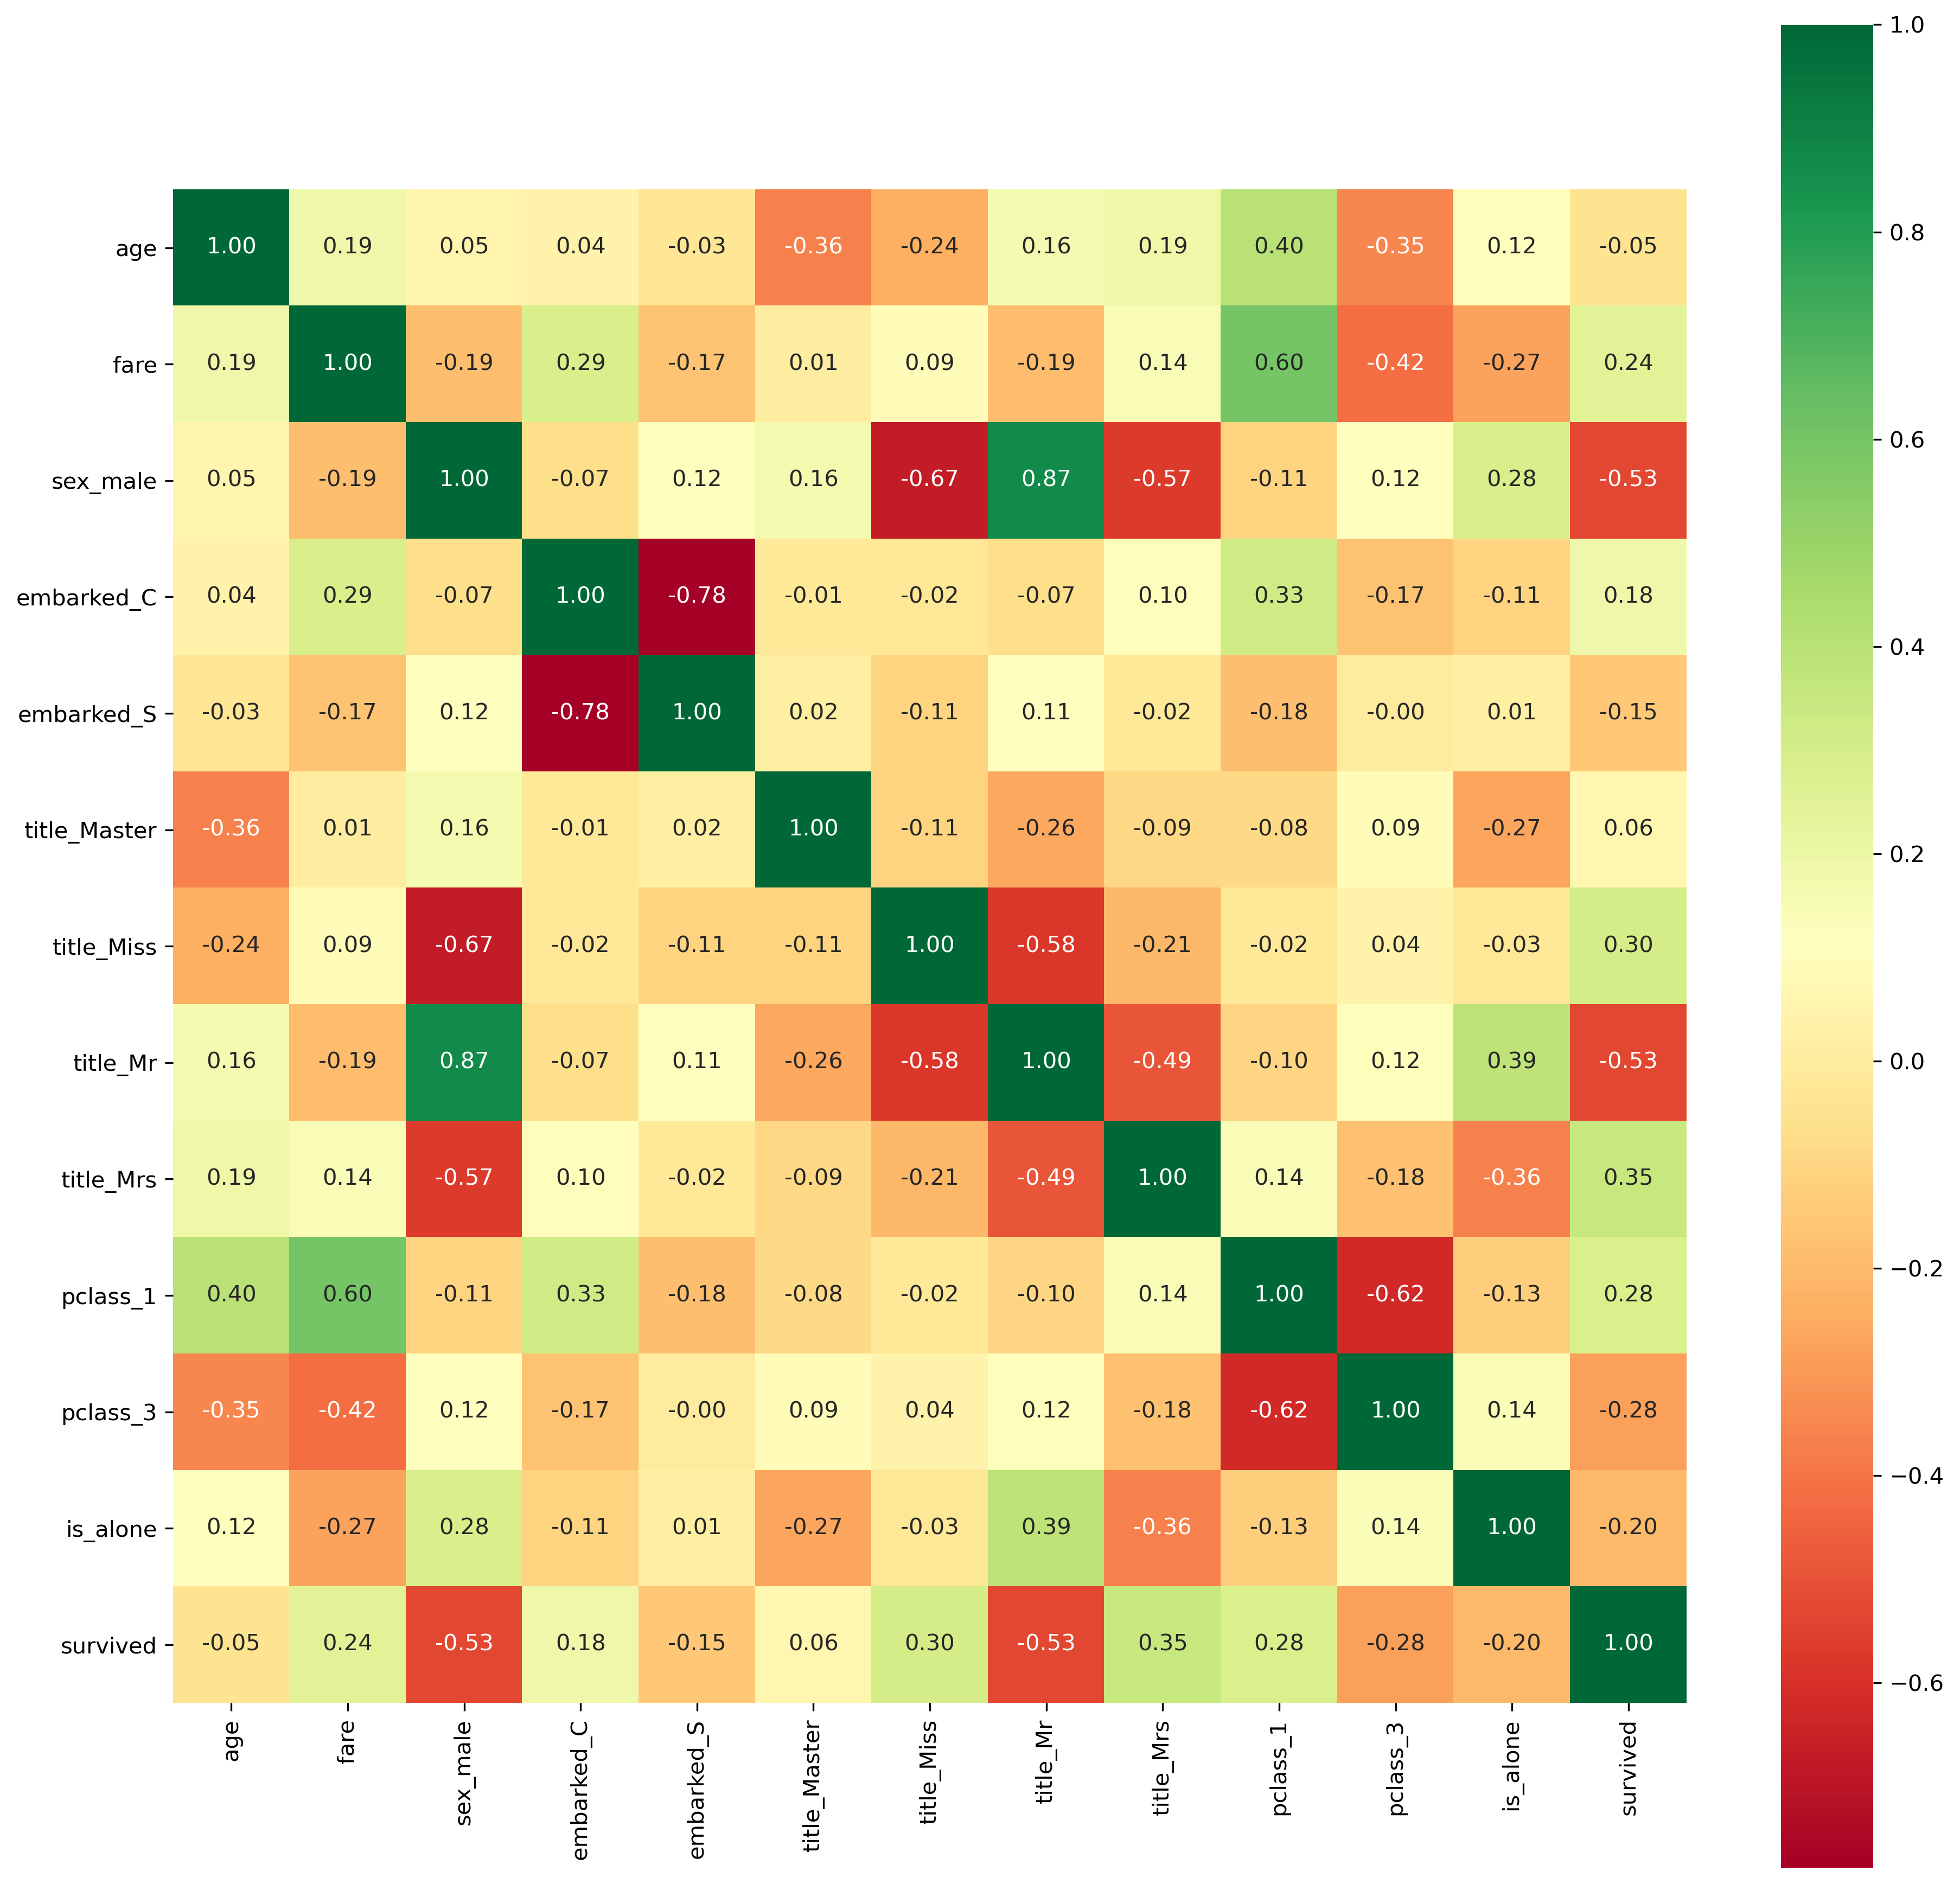

In [706]:
sns.heatmap(df_preprocessed.corr(), annot=True, cmap='RdYlGn', square=True, fmt='.2f');

In [707]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV

def select_features(X_train, y_train, target):
    all_cols = X_train.columns
    lr = LinearRegression()
    selector = RFECV(lr, cv=10, step=1)
    selector.fit(X_train, y_train)
    
    best_columns = list(X_train.columns[selector.support_])
    removed_cols = [col for col in all_cols if col not in best_columns]
    if len(removed_cols) > 0:
        print("removed:")
        print(removed_cols)
    else:
        print("kept everything")
    return best_columns


features = select_features(X_train, y_train, target="survived")
features

removed:
['fare']


['age',
 'sex_male',
 'embarked_C',
 'embarked_S',
 'title_Master',
 'title_Miss',
 'title_Mr',
 'title_Mrs',
 'pclass_1',
 'pclass_3',
 'is_alone']

In [708]:
X_train, X_test = X_train[features], X_test[features]

<a id="hyperparameterOptimization"><a/>

## Hyperparameter Optimization

In [709]:
from sklearn.model_selection import GridSearchCV

def get_best_model(X_train, y_train, models): 
    for model in models:
        print(model['name'])
        print('-' * len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(X_train, y_train)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

In [710]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

models = [
    {
        "name": "K Nearest Neighbors",
        "estimator": KNeighborsClassifier(),
        "hyperparameters":
            {
                "n_neighbors": [2, 3, 4, 5, 7, 10, 15, 20],
                "weights": ["uniform", "distance"],
                "p": [1, 2]
            }
    },
    {
        "name": "Linear Support Vector Machines Classifier",
        "estimator": svm.LinearSVC(),
        "hyperparameters":
            {
                "loss": ["hinge", "squared_hinge"]
            }
    },
    {
        "name": "Linear Discriminant Analysis",
        "estimator": LinearDiscriminantAnalysis(),
        "hyperparameters":
            {
                "solver": ["svd", "lsqr", "eigen"]
            }
    },
    {
        "name": "Logistic Regressor",
        "estimator": LogisticRegression(),
        "hyperparameters":
            {
                "solver": ["lbfgs", "sag", "saga"],
                "max_iter": [100, 300, 500, 1000]
            }
    },
    {
        "name": "Decision Tree Classifier",
        "estimator": DecisionTreeClassifier(),
        "hyperparameters":
            {
                "criterion": ["gini", "entropy"],
                "splitter": ["best", "random"],
                "max_depth": [5, 7, 10, 15, 25, None]
            }
    },
    {
        "name": "Random Forest Classifier",
        "estimator": RandomForestClassifier(),
        "hyperparameters":
            {
                "criterion": ["gini", "entropy"],
                "max_depth": [5, 7, 10, 15, 25, None]
            }
    },
    {
        "name": "Gradient Boosting Classifier",
        "estimator": GradientBoostingClassifier(),
        "hyperparameters":
            {
                "loss": ["deviance", "exponential"],
                "learning_rate": [.1, .2, .5],
                "max_depth": [5, 7, 10, 15, 25, None]
            }
    },
    {
        "name": "Ada Boost Classifier",
        "estimator": AdaBoostClassifier(),
        "hyperparameters":
            {
            }
    }
]

In [711]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [712]:
best_models = get_best_model(X_train, y_train, models)

K Nearest Neighbors
-------------------
Best Score: 0.8031684981684981
Best Parameters: {'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}

Linear Support Vector Machines Classifier
-----------------------------------------
Best Score: 0.7926190476190477
Best Parameters: {'loss': 'squared_hinge'}

Linear Discriminant Analysis
----------------------------
Best Score: 0.7926190476190477
Best Parameters: {'solver': 'svd'}

Logistic Regressor
------------------
Best Score: 0.797408424908425
Best Parameters: {'max_iter': 100, 'solver': 'lbfgs'}

Decision Tree Classifier
------------------------
Best Score: 0.8089010989010988
Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'splitter': 'random'}

Random Forest Classifier
------------------------
Best Score: 0.8098626373626374
Best Parameters: {'criterion': 'entropy', 'max_depth': 5}

Gradient Boosting Classifier
----------------------------
Best Score: 0.7908699633699634
Best Parameters: {'learning_rate': 0.1, 'loss': 'exponential', 'ma

In [713]:
vault_names = [
    "K Nearest Neighbors", 
    "Linear Support Vector Machines Classifier", 
    "Linear Discriminant Analysis",
    "Logistic Regressor",
    "Decision Tree Classifier"
]
models_to_vault = [(model["name"], model["best_model"]) for model in best_models if model["name"] in vault_names]
models_to_vault

[('K Nearest Neighbors', KNeighborsClassifier(n_neighbors=20, p=1)),
 ('Linear Support Vector Machines Classifier', LinearSVC()),
 ('Linear Discriminant Analysis', LinearDiscriminantAnalysis()),
 ('Logistic Regressor', LogisticRegression()),
 ('Decision Tree Classifier',
  DecisionTreeClassifier(max_depth=5, splitter='random'))]

In [714]:
from sklearn.ensemble import VotingClassifier

vote_model = [
    {
        "name": "Voting Classifier",
        "estimator": VotingClassifier(estimators=models_to_vault),
        "hyperparameters":
            {
                "voting": ["hard"],
                "n_jobs": [-1]
            }
    }
]

In [715]:
best_voting = get_best_model(X_train, y_train, vote_model)

Voting Classifier
-----------------
Best Score: 0.7974175824175824
Best Parameters: {'n_jobs': -1, 'voting': 'hard'}



<a id="modelSelection"><a/>

## Model Selection

In [716]:
all_models = best_models + best_voting
models_df = pd.DataFrame(
    {
        "model_name": [model["name"] for model in all_models], 
        "score": [model["best_score"] for model in all_models]
    }
)
models_df = models_df.sort_values("score", ascending=False)
models_df

,model_name,score
5,Random Forest Classifier,0.809863
4,Decision Tree Classifier,0.808901
0,K Nearest Neighbors,0.803168
8,Voting Classifier,0.797418
3,Logistic Regressor,0.797408
1,Linear Support Vector Machines Classifier,0.792619
2,Linear Discriminant Analysis,0.792619
6,Gradient Boosting Classifier,0.790870
7,Ada Boost Classifier,0.782189


In [812]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import time

def get_metrics_of_model(model, X_test, y_test):
    start_time = time.time()
    predictions = model.predict(X_test)
    delay = time.time() - start_time
    predict_time_per_row_ms = delay / len(X_test) * 1000
    
    labels = ["Died", "Survived"]
    classification_report_dict = classification_report(y_test, predictions, output_dict=True, target_names=labels)
    d = classification_report_dict["Died"]
    accuracy, precision, recall, f1_score = classification_report_dict["accuracy"], d["precision"], d["recall"], d["f1-score"]
    
    c_m = confusion_matrix(y_test, predictions)
    
    return accuracy, precision, recall, f1_score, c_m, predict_time_per_row_ms

def get_all_metrics_df(models, model_names, X_test, y_test):
    all_metrics = [get_metrics_of_model(m, X_test, y_test) for m in models]
    metric_names = ["accuracy", "precision", "recall", "f1_score", "confusion_matrix", "predict_time_ms"]
    metrics = [[metrics_tuple[i] for metrics_tuple in all_metrics] for i in range(len(metric_names))]
    
    data = [model_names] + metrics
    columns = ["model"] + metric_names
    metrics_dict = {metric_names[i]: metrics[i] for i in range(len(metric_names))}
    df_dict = {"model": model_names}
    df_dict.update(metrics_dict)
    df = pd.DataFrame(df_dict)
    return df

In [814]:
all_ms = [m["best_model"] for m in best_models + best_voting]
all_names = [m["name"] for m in best_models + best_voting]
get_all_metrics_df(all_ms, all_names, X_test, y_test)

,model,accuracy,precision,recall,f1_score,confusion_matrix,predict_time_ms
0,K Nearest Neighbors,0.809160,0.773196,0.961538,0.857143,"[[150, 6], [44, 62]]",0.057270
1,Linear Support Vector Machines Classifier,0.820611,0.834356,0.871795,0.852665,"[[136, 20], [27, 79]]",0.007639
2,Linear Discriminant Analysis,0.820611,0.834356,0.871795,0.852665,"[[136, 20], [27, 79]]",0.007677
3,Logistic Regressor,0.809160,0.815476,0.878205,0.845679,"[[137, 19], [31, 75]]",0.007639
4,Decision Tree Classifier,0.793893,0.762887,0.948718,0.845714,"[[148, 8], [46, 60]]",0.007676
5,Random Forest Classifier,0.805344,0.766497,0.967949,0.855524,"[[151, 5], [46, 60]]",0.053487
6,Gradient Boosting Classifier,0.801527,0.788889,0.910256,0.845238,"[[142, 14], [38, 68]]",0.011465
7,Ada Boost Classifier,0.790076,0.817610,0.833333,0.825397,"[[130, 26], [29, 77]]",0.042021
8,Voting Classifier,0.816794,0.817647,0.891026,0.852761,"[[139, 17], [31, 75]]",0.087865


In [788]:
a = [[1, 2, 3], [1, 2, 3]]
[[b[i] for b in a] for i in range(3)]

[[1, 1], [2, 2], [3, 3]]

In [760]:
[["a", "b"]] + [[1, 2], [3, 4]]

[['a', 'b'], [1, 2], [3, 4]]

In [750]:
m = get_metrics(best_voting[0]["best_model"], X_test, y_test)
m

(0.816793893129771,
 0.8176470588235294,
 0.8910256410256411,
 0.852760736196319,
 156,
 array([[139,  17],
        [ 31,  75]], dtype=int64))

In [738]:

predictions = best_voting[0]["best_model"].predict(X_test)
confusion_matrix(y_test, predictions)

array([[139,  17],
       [ 31,  75]], dtype=int64)